## 1. Import Packages:

In [1]:
import os ## System Library
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib import rc
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, plot_tree
from matplotlib.dates import DateFormatter, MonthLocator

## 2. Financial Dataset: FR-Y 9C 

In [2]:
# Path to the folder containing the text files
folder_path = r"/Users/harshitaagrawal/Desktop/Capstone Project/Financial Data Download 2004-2024"

# List all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')] ## List Comprehension

# Initialize an empty list to store DataFrames
dataframes = []

# Read each file and append the DataFrame to the list
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep='^', header=0, engine='python', encoding='latin1', on_bad_lines='skip')
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_df.head()

,RSSD9001,RSSD9999,RSSD9007,RSSD9008,RSSD9132,RSSD9032,RSSD9146,BHBC3368,BHBC3402,BHBC3516,...,BHCKLG24,BHCKLG25,BHCKLG26,BHCKLG27,BHCKLG28,BHCKLL57,BHCKG894,TEXTC490,BHCWKX78,BHCWKX83
0,1020180,20180331,20151231,20230521,551111,9,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1020201,20180331,20151231,99991231,551111,7,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1020676,20180331,20150906,99991231,551111,7,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1020902,20180331,20140805,99991231,551111,10,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1022764,20180331,20170517,99991231,551111,12,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
combined_df.shape

(243757, 3099)

### -  Subset of Columns:

In [4]:
smalldf = combined_df[['RSSD9001', 'RSSD9007', 'RSSD9017', 'RSSD9032', 'RSSD9146', 'RSSD9999', 'BHCK2170', 'BHCK4107', 'BHCK4073', 'BHCK4074', 'BHCK4079', 'BHCK4093']]
smalldf.head()

,RSSD9001,RSSD9007,RSSD9017,RSSD9032,RSSD9146,RSSD9999,BHCK2170,BHCK4107,BHCK4073,BHCK4074,BHCK4079,BHCK4093
0,1020180,20151231,BREMER FINANCIAL CORPORATION,9,1.0,20180331,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0
1,1020201,20151231,HSBC USA INC.,7,2.0,20180331,NaN,NaN,NaN,NaN,NaN,NaN
2,1020676,20150906,AMALGAMATED INVESTMENTS COMPANY,7,1.0,20180331,778831.0,6679.0,244.0,6435.0,4839.0,9376.0
3,1020902,20140805,"FIRST NATIONAL OF NEBRASKA, INC.",10,1.0,20180331,19950623.0,322364.0,24664.0,297700.0,99888.0,224265.0
4,1022764,20170517,CENTRAL PACIFIC FINANCIAL CORP.,12,1.0,20180331,5651287.0,47310.0,4988.0,42322.0,8692.0,33259.0


In [5]:
name_dict = {'RSSD9001':'RSSD ID',
             'RSSD9007':'Start Date',
             'RSSD9008':'End Date',
             'RSSD9017':'Firm Legal Name',
             'RSSD9032':'FR District Code',
             'RSSD9146':'Bank Count',
             'RSSD9999':'Reporting Date',
             'BHCK2170':'Total Assets', 
             'BHCK4073':'Interest Expense',
             'BHCK4107':'Interest Income Year-to-Date',
             'BHCK4074':'Net Interest Income',
             'BHCK4079':'Non-Interest Income Year-to-Date',
             'BHCK4093':'Non-Interest Expense'}
smalldf = smalldf.rename(columns = name_dict).sort_values(by = ['RSSD ID'])
smalldf.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense
0,1020180,20151231,BREMER FINANCIAL CORPORATION,9,1.0,20180331,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0
66758,1020180,20061231,BREMER FINANCIAL CORPORATION,9,9.0,20061231,6751806.0,431501.0,199052.0,232449.0,80037.0,195618.0
122298,1020180,20051231,BREMER FINANCIAL CORPORATION,9,9.0,20060331,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0
238323,1020180,20081231,BREMER FINANCIAL CORPORATION,9,9.0,20091231,7799981.0,383385.0,104692.0,278693.0,95028.0,233117.0
72467,1020180,20151231,BREMER FINANCIAL CORPORATION,9,1.0,20190630,12745024.0,249584.0,58329.0,191255.0,52882.0,152837.0


In [6]:
smalldf.shape

(243757, 12)

### -  Change Date Format:

In [7]:
smalldf['Reporting Date'] = pd.to_datetime(smalldf['Reporting Date'].astype(str), utc=True)
smalldf['Start Date'] = pd.to_datetime(smalldf['Start Date'].astype(str), utc=True)
smalldf.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense
0,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-03-31 00:00:00+00:00,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0
66758,1020180,2006-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-12-31 00:00:00+00:00,6751806.0,431501.0,199052.0,232449.0,80037.0,195618.0
122298,1020180,2005-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-03-31 00:00:00+00:00,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0
238323,1020180,2008-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2009-12-31 00:00:00+00:00,7799981.0,383385.0,104692.0,278693.0,95028.0,233117.0
72467,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2019-06-30 00:00:00+00:00,12745024.0,249584.0,58329.0,191255.0,52882.0,152837.0


### -  Define Quarters and Year:

In [8]:
smalldf['Quarter'] = smalldf['Reporting Date'].dt.quarter
smalldf['Year'] = smalldf['Reporting Date'].dt.year
smalldf.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense,Quarter,Year
0,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-03-31 00:00:00+00:00,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0,1,2018
66758,1020180,2006-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-12-31 00:00:00+00:00,6751806.0,431501.0,199052.0,232449.0,80037.0,195618.0,4,2006
122298,1020180,2005-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-03-31 00:00:00+00:00,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0,1,2006
238323,1020180,2008-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2009-12-31 00:00:00+00:00,7799981.0,383385.0,104692.0,278693.0,95028.0,233117.0,4,2009
72467,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2019-06-30 00:00:00+00:00,12745024.0,249584.0,58329.0,191255.0,52882.0,152837.0,2,2019


### - Quarterization:

In [9]:
def f(val):
    global last_val
    new_val = val - last_val
    last_val = val
    return new_val

In [10]:
# Quarterization for Interest Income year-to-date

new_dfs = []
for i in smalldf['RSSD ID'].unique():
  new_df_i = smalldf.loc[smalldf['RSSD ID']==i,:]
  for j in smalldf['Year'].unique():
    new_df_i_j = new_df_i.loc[smalldf['Year']==j,:]
    new_df_i_j = new_df_i_j.sort_values('Quarter')
    last_val = 0
    new_df_i_j['Interest Income per Quarter'] = new_df_i_j['Interest Income Year-to-Date'].apply(f)
    new_dfs.append(new_df_i_j)

Quarterized_dfs = pd.concat(new_dfs, ignore_index=True)
Quarterized_dfs.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense,Quarter,Year,Interest Income per Quarter
0,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-03-31 00:00:00+00:00,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0,1,2018,108983.0
1,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-06-30 00:00:00+00:00,12077601.0,224623.0,36271.0,188352.0,60958.0,159789.0,2,2018,115640.0
2,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-09-30 00:00:00+00:00,12119987.0,342266.0,58552.0,283714.0,91838.0,239242.0,3,2018,117643.0
3,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-12-31 00:00:00+00:00,12192038.0,462684.0,83107.0,379577.0,124334.0,325762.0,4,2018,120418.0
4,1020180,2005-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-03-31 00:00:00+00:00,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0,1,2006,100170.0


### -  Normalization:

In [11]:
Quarterized_dfs['Normalized Interest Income per Quarter'] = Quarterized_dfs['Interest Income per Quarter']/Quarterized_dfs['Total Assets']
Quarterized_dfs.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense,Quarter,Year,Interest Income per Quarter,Normalized Interest Income per Quarter
0,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-03-31 00:00:00+00:00,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0,1,2018,108983.0,0.009112
1,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-06-30 00:00:00+00:00,12077601.0,224623.0,36271.0,188352.0,60958.0,159789.0,2,2018,115640.0,0.009575
2,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-09-30 00:00:00+00:00,12119987.0,342266.0,58552.0,283714.0,91838.0,239242.0,3,2018,117643.0,0.009707
3,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-12-31 00:00:00+00:00,12192038.0,462684.0,83107.0,379577.0,124334.0,325762.0,4,2018,120418.0,0.009877
4,1020180,2005-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-03-31 00:00:00+00:00,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0,1,2006,100170.0,0.015457


In [12]:
Quarterized_dfs.shape

(243757, 16)

## 3. Yield Curve Rates:

In [13]:
rates_df = pd.read_csv("~/Desktop/Capstone Project/yield-curve-rates-2004-2024.csv")
rates_df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,07/15/2024,5.48,5.51,5.43,5.40,5.23,4.85,4.44,4.23,4.13,4.16,4.23,4.56,4.46
1,07/12/2024,5.47,5.52,5.43,5.41,5.23,4.87,4.45,4.22,4.10,4.13,4.18,4.50,4.39
2,07/11/2024,5.48,5.53,5.44,5.41,5.25,4.91,4.50,4.26,4.13,4.15,4.20,4.51,4.41
3,07/10/2024,5.46,5.50,5.46,5.46,5.33,5.01,4.62,4.38,4.24,4.24,4.28,4.58,4.47
4,07/09/2024,5.45,5.51,5.46,5.46,5.34,5.02,4.62,4.37,4.24,4.25,4.30,4.59,4.49


In [14]:
rates_df.shape

(5139, 14)

### -  Changing Date to Date-time Format:  

In [15]:
rates_df['Date'] = pd.to_datetime(rates_df['Date'].astype(str), format='mixed', utc=True)
rates_df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2024-07-15 00:00:00+00:00,5.48,5.51,5.43,5.40,5.23,4.85,4.44,4.23,4.13,4.16,4.23,4.56,4.46
1,2024-07-12 00:00:00+00:00,5.47,5.52,5.43,5.41,5.23,4.87,4.45,4.22,4.10,4.13,4.18,4.50,4.39
2,2024-07-11 00:00:00+00:00,5.48,5.53,5.44,5.41,5.25,4.91,4.50,4.26,4.13,4.15,4.20,4.51,4.41
3,2024-07-10 00:00:00+00:00,5.46,5.50,5.46,5.46,5.33,5.01,4.62,4.38,4.24,4.24,4.28,4.58,4.47
4,2024-07-09 00:00:00+00:00,5.45,5.51,5.46,5.46,5.34,5.02,4.62,4.37,4.24,4.25,4.30,4.59,4.49


### -  Giving the Year and Quarter each entry:

In [16]:
rates_df['Year'] = rates_df['Date'].dt.year
rates_df['Quarter'] = rates_df['Date'].dt.quarter
rates_df.sort_values('Date').head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Year,Quarter
5138,2004-01-02 00:00:00+00:00,0.88,NaN,0.93,NaN,1.02,1.31,1.94,2.47,3.36,3.90,4.38,5.21,NaN,2004,1
5137,2004-01-05 00:00:00+00:00,0.88,NaN,0.91,NaN,1.05,1.35,1.95,2.51,3.39,3.92,4.41,5.23,NaN,2004,1
5136,2004-01-06 00:00:00+00:00,0.88,NaN,0.91,NaN,1.03,1.30,1.84,2.38,3.26,3.80,4.29,5.13,NaN,2004,1
5135,2004-01-07 00:00:00+00:00,0.88,NaN,0.91,NaN,1.02,1.29,1.84,2.36,3.25,3.76,4.27,5.11,NaN,2004,1
5134,2004-01-08 00:00:00+00:00,0.87,NaN,0.88,NaN,1.01,1.29,1.85,2.37,3.24,3.76,4.27,5.12,NaN,2004,1


In [17]:
finalrates = rates_df.groupby(['Year', 'Quarter']).mean()
finalrates.head(8)

Date      1 Mo  2 Mo      3 Mo  \
Year Quarter                                                                 
2004 1       2004-02-16 08:30:58.064516096+00:00  0.909677   NaN  0.933710   
     2       2004-05-16 03:29:01.935483904+00:00  0.954516   NaN  1.096129   
     3                 2004-08-16 05:15:00+00:00  1.370000   NaN  1.513906   
     4       2004-11-16 05:01:56.129032320+00:00  1.841774   NaN  2.047419   
2005 1       2005-02-15 01:58:01.967213056+00:00  2.360984   NaN  2.589180   
     2                 2005-05-16 09:22:30+00:00  2.709687   NaN  2.926719   
     3                 2005-08-16 15:45:00+00:00  3.228594   NaN  3.438281   
     4       2005-11-15 21:38:21.639344256+00:00  3.702131   NaN  3.913607   

              4 Mo      6 Mo      1 Yr      2 Yr      3 Yr      5 Yr  \
Year Quarter                                                           
2004 1         NaN  1.003548  1.221452  1.686613  2.163065  2.980968   
     2         NaN  1.359677  1.775484  2.454677  2.971935  3.720968   
     3         NaN  1.788437  2.075000  2.556563  2.919531  3.505625   
     4         NaN  2.297581  2.472742  2.822419  3.058871  3.493710   
2005 1         NaN  2.876885  3.072459  3.454918  3.623934  3.890820   
     2         NaN  3.179688  3.337344  3.645938  3.732344  3.872969   
     3         NaN  3.707031  3.791094  3.957969  3.989219  4.039375   
     4         NaN  4.250492  4.288525  4.364590  4.372295  4.391148   

                  7 Yr     10 Yr     20 Yr  30 Yr  
Year Quarter                                       
2004 1        3.501452  4.010000  4.877903    NaN  
     2        4.183871  4.597097  5.355645    NaN  
     3        3.922188  4.301406  5.068281    NaN  
     4        3.855000  4.175806  4.874839    NaN  
2005 1        4.098852  4.303607  4.764098    NaN  
     2        3.984688  4.158594  4.548750    NaN  
     3        4.108437  4.215156  4.507656    NaN  
     4        4.425738  4.488197  4.767541    NaN

### -  Daily Treasury Curve:

The importance of different Treasury rates can depend on the context and the financial instruments or decisions involved. However, some Treasury rates are generally considered more significant due to their broader economic implications and their use as benchmarks:

1. **10-Year Treasury Yield:**

-  Significance: Often regarded as a key indicator of investor sentiment and economic health. It's widely used as a benchmark for mortgage rates and other long-term loans.
-  Impact: Movements in the 10-year yield can influence borrowing costs for consumers and businesses, affecting spending and investment decisions.

2. **2-Year Treasury Yield:**

-  Significance: Closely watched as a gauge of Federal Reserve monetary policy expectations. Changes in the 2-year yield can reflect market expectations for future interest rate movements.
-  Impact: It's often used to understand short-term economic outlooks and the stance of monetary policy.

3. **30-Year Treasury Yield:**

-  Significance: Important for long-term investments and planning, such as retirement funds and insurance companies. It reflects long-term economic growth expectations and inflation.
-  Impact: Affects the pricing of long-term loans, mortgages, and other financial products.

4. **5-Year Treasury Yield:**

-  Significance: A middle ground between short-term and long-term rates, providing insights into medium-term economic conditions and expectations.
-  Impact: Influences intermediate-term loans and financing.

5. **3-Month Treasury Bill Rate:**

- Significance: Viewed as a safe haven and a benchmark for short-term interest rates. It's often used in calculating discount rates and as a reference for money market instruments.
- Impact: Reflects liquidity conditions and short-term interest rate expectations.

### -  Key Points of Interest:

-  **Yield Curve:** The relationship between short-term and long-term Treasury yields, which can signal economic conditions. A normal upward-sloping yield curve indicates healthy economic growth, while an inverted yield curve can signal a potential recession.

- **Inflation Expectations:** Treasury rates can provide insights into market expectations for inflation, with higher rates often indicating higher inflation expectations.

- **Federal Reserve Policy:** The Fed's actions, such as rate hikes or cuts, directly influence short-term Treasury yields and can also affect longer-term yields through expectations and market reactions.

Each Treasury rate serves a different purpose and offers unique insights into various aspects of the economy and financial markets. Understanding the context and the specific financial decision at hand is crucial in determining which Treasury rate is most important.

In [18]:
# Adjusting font
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

### -  Visualization of all Rates presented in the Dataset over Time:

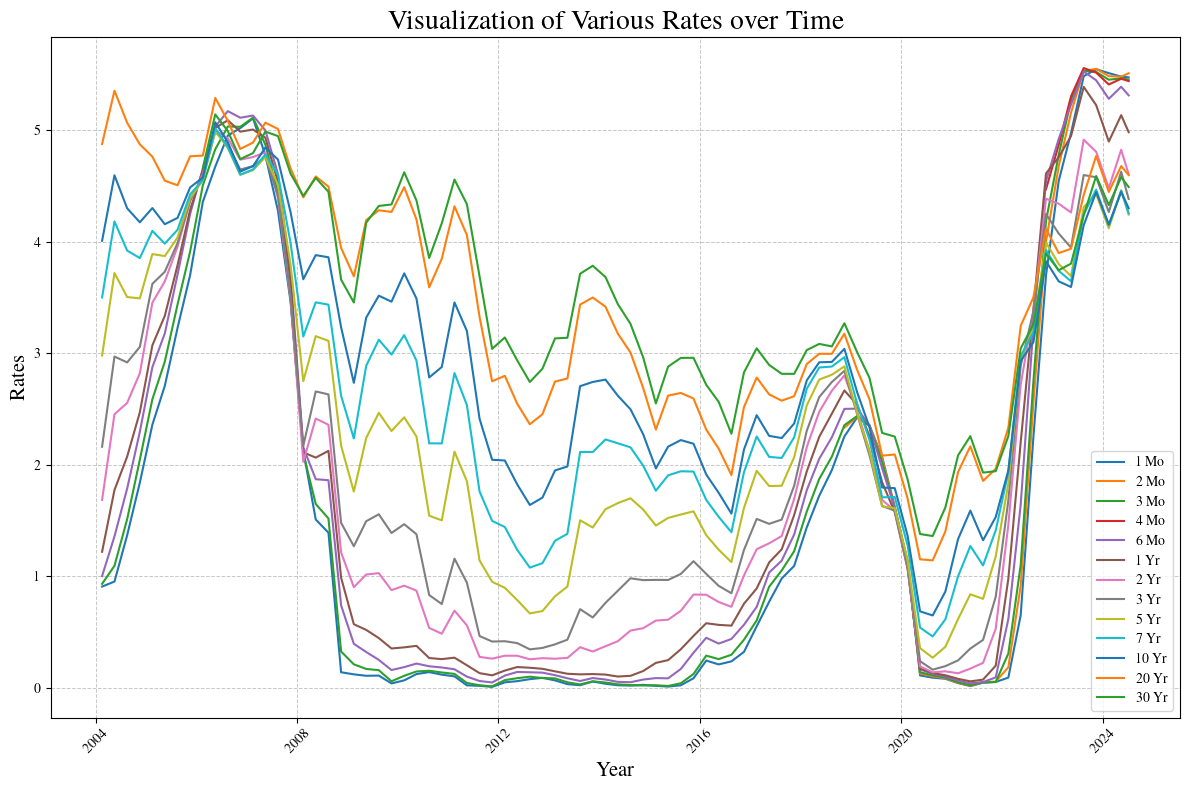

In [19]:
# Adjusting the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Creating the plot
for col in ['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']:
    ax.plot(finalrates['Date'], finalrates[col], label=col)

# Adding a plot title and customizing its font size
ax.set_title('Visualization of Various Rates over Time', fontsize=20)

# Adding axis labels and customizing their font size
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Rates', fontsize=15)

# Customizing the x-axis major and minor ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improving layout for tight fit
plt.tight_layout()

# Making a legend for the colors
ax.legend();

**Interpretation:** 

If the graph shows that short-term rates (like 1-month and 2-month rates) have been rising steadily while long-term rates (like 10-year and 30-year rates) remain relatively flat, it might suggest an economic scenario where the central bank is increasing rates to combat inflation, but the long-term outlook remains uncertain.

Conversely, if all rates are rising together, it could indicate overall economic growth and increased expectations of future inflation.

### - Visualization of a subset of Rates over Time:

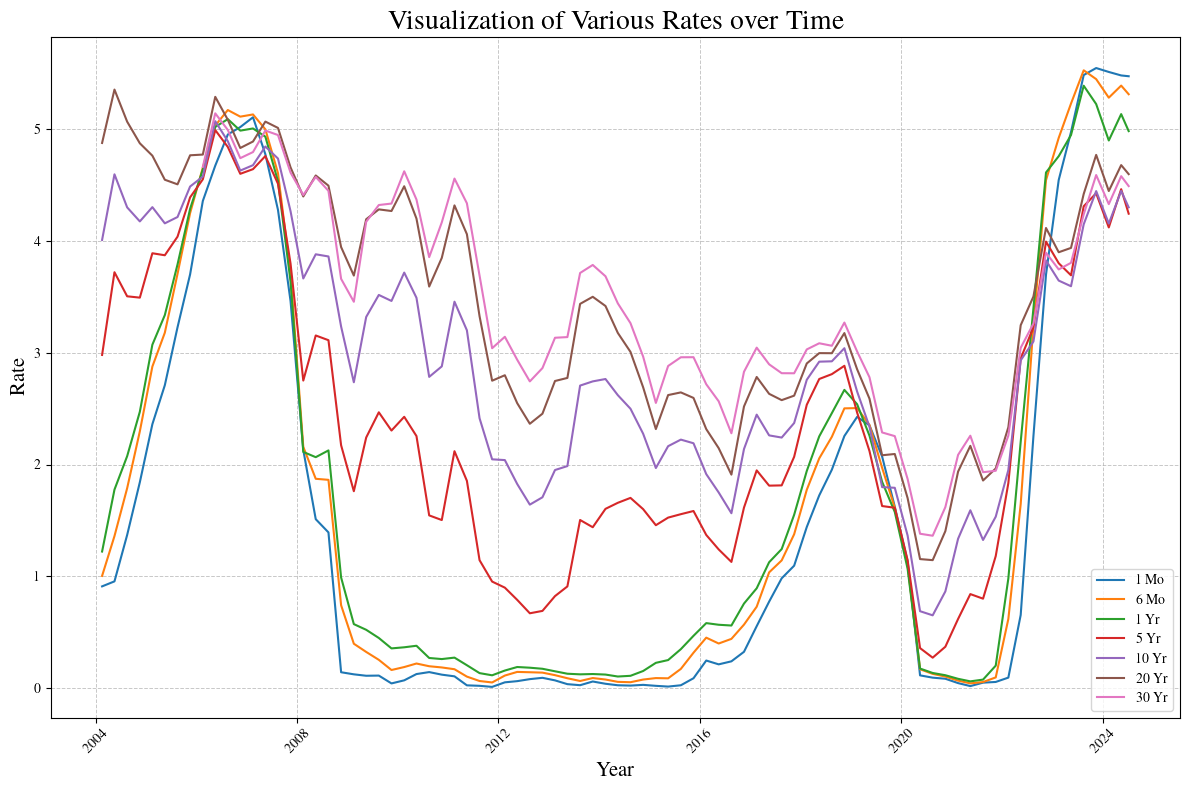

In [20]:
# Making a smaller plot with fewer rates included

# Adjusting the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Creating the plot
for col in ['1 Mo', '6 Mo', '1 Yr', '5 Yr', '10 Yr', '20 Yr', '30 Yr']:
    ax.plot(finalrates['Date'], finalrates[col], label=col)

# Adding a plot title and customizing its font size
ax.set_title('Visualization of Various Rates over Time', fontsize=20)

# Adding axis labels and customizing their font size
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Rate', fontsize=15)

# Customizing the x-axis major and minor ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improving layout for tight fit
plt.tight_layout()

# Making a legend for the colors
ax.legend();

### - Highlighting Periods where Short Term Interest Rates are Bigger than Long Term:

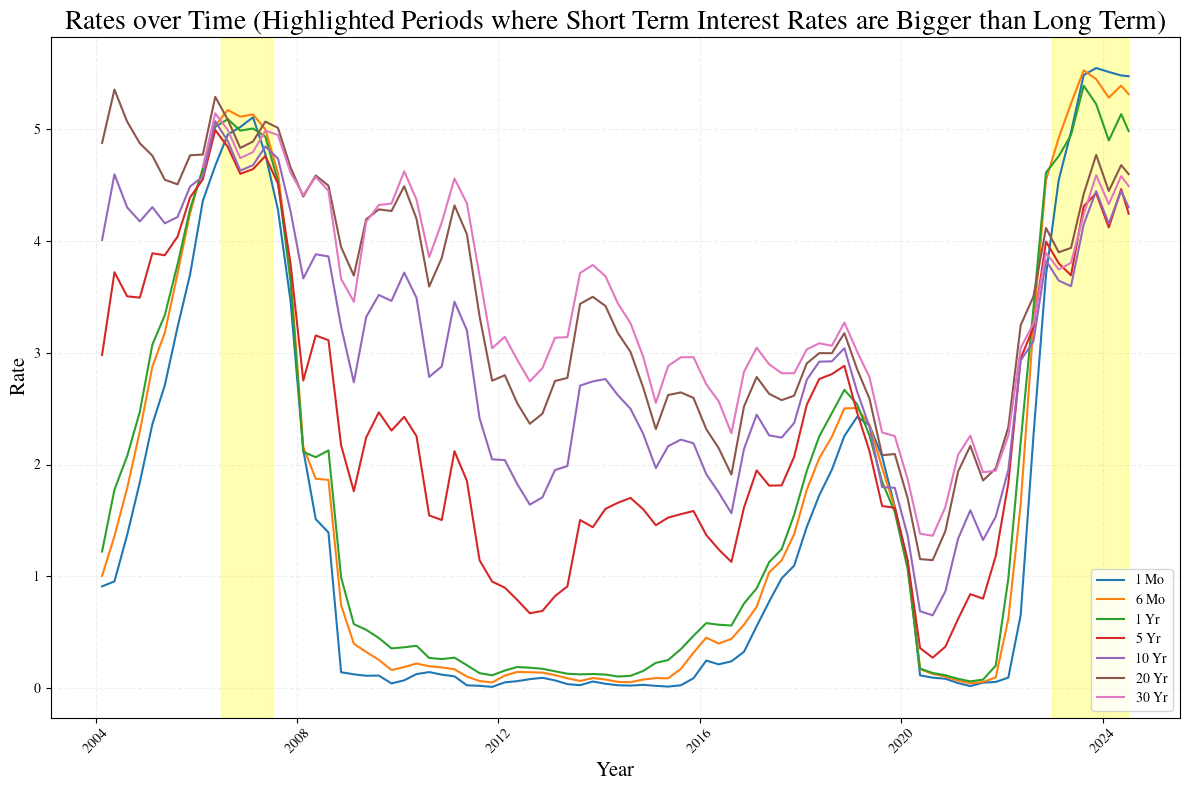

In [21]:
# Adjusting the figure size and creating a subplot
fig, ax = plt.subplots(figsize=(12, 8))

# Creating the plot
for col in ['1 Mo', '6 Mo', '1 Yr', '5 Yr', '10 Yr', '20 Yr', '30 Yr']:
    ax.plot(finalrates['Date'], finalrates[col], label=col)

# Adding a plot title and customizing its font size
ax.set_title('Rates over Time (Highlighted Periods where Short Term Interest Rates are Bigger than Long Term)', fontsize=20, fontweight='bold')

# Adding axis labels and customizing their font size
ax.set_xlabel('Year', fontsize=15, fontweight='bold')
ax.set_ylabel('Rate', fontsize=15, fontweight='bold')

# Adding a legend with customized position and font size
ax.legend(loc='lower right', fontsize=10)

# Highlighting the time period from 2006-06-30 to 2007-06-30 
ax.axvspan(datetime(2006, 6, 30), datetime(2007, 6, 30), color='yellow', alpha=0.3)

# Highlighting the time period from 2022-12-31 to 2024-07-01 
ax.axvspan(datetime(2022, 12, 31), datetime(2024, 7, 1), color='yellow', alpha=0.3)

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.9, alpha=0.2)

# Improving layout for tight fit
plt.tight_layout()

plt.show()

-  **Highlighting Specific Periods:** The yellow highlighted areas indicate specific time periods where short-term interest rates were greater than long-term interest rates. This can suggest periods of economic stress or unusual market conditions, such as during financial crises or major economic events.
-  **Yield Curve Inversion:** Typically, long-term rates are higher than short-term rates. When this relationship reverses, it can signal an inverted yield curve, which is often seen as a predictor of economic recessions.

In [22]:
finalrates_df = finalrates.copy()
finalrates_df = finalrates_df.drop(columns=["Date"])
finalrates_df.reset_index(inplace=True)
finalrates_df.head()

,Year,Quarter,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2004,1,0.909677,NaN,0.933710,NaN,1.003548,1.221452,1.686613,2.163065,2.980968,3.501452,4.010000,4.877903,NaN
1,2004,2,0.954516,NaN,1.096129,NaN,1.359677,1.775484,2.454677,2.971935,3.720968,4.183871,4.597097,5.355645,NaN
2,2004,3,1.370000,NaN,1.513906,NaN,1.788437,2.075000,2.556563,2.919531,3.505625,3.922188,4.301406,5.068281,NaN
3,2004,4,1.841774,NaN,2.047419,NaN,2.297581,2.472742,2.822419,3.058871,3.493710,3.855000,4.175806,4.874839,NaN
4,2005,1,2.360984,NaN,2.589180,NaN,2.876885,3.072459,3.454918,3.623934,3.890820,4.098852,4.303607,4.764098,NaN


### -  Function to modify the format of dates:

In [23]:
def chain_date(date_str):
    for fmt in ('%m/%d/%Y', '%m/%d/%y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.NaT

In [24]:
rates_df['Date'] = rates_df['Date'].apply(chain_date)
copy_df = rates_df.copy()
copy_df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Year,Quarter
0,2024-07-15 00:00:00+00:00,5.48,5.51,5.43,5.40,5.23,4.85,4.44,4.23,4.13,4.16,4.23,4.56,4.46,2024,3
1,2024-07-12 00:00:00+00:00,5.47,5.52,5.43,5.41,5.23,4.87,4.45,4.22,4.10,4.13,4.18,4.50,4.39,2024,3
2,2024-07-11 00:00:00+00:00,5.48,5.53,5.44,5.41,5.25,4.91,4.50,4.26,4.13,4.15,4.20,4.51,4.41,2024,3
3,2024-07-10 00:00:00+00:00,5.46,5.50,5.46,5.46,5.33,5.01,4.62,4.38,4.24,4.24,4.28,4.58,4.47,2024,3
4,2024-07-09 00:00:00+00:00,5.45,5.51,5.46,5.46,5.34,5.02,4.62,4.37,4.24,4.25,4.30,4.59,4.49,2024,3


### -  Function to assign quarters:

In [25]:
def assign_quarter(date):
    month = date.month
    if month in [1, 2, 3]:
        return 'Q1'
    elif month in [4, 5, 6]:
        return 'Q2'
    elif month in [7, 8, 9]:
        return 'Q3'
    else:
        return 'Q4'

In [26]:
# Asisign the quarters in a new column
copy_df['Quarter'] = copy_df['Date'].apply(assign_quarter)
copy_df['Year'] = copy_df['Date'].dt.year

In [27]:
# Group by quarter and calculate the average of all columns except 'Date'
quarterly_averages = copy_df.groupby(['Year', 'Quarter']).mean(numeric_only=True).reset_index()
quarterly_averages.head(8)

,Year,Quarter,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2004,Q1,0.909677,NaN,0.933710,NaN,1.003548,1.221452,1.686613,2.163065,2.980968,3.501452,4.010000,4.877903,NaN
1,2004,Q2,0.954516,NaN,1.096129,NaN,1.359677,1.775484,2.454677,2.971935,3.720968,4.183871,4.597097,5.355645,NaN
2,2004,Q3,1.370000,NaN,1.513906,NaN,1.788437,2.075000,2.556563,2.919531,3.505625,3.922188,4.301406,5.068281,NaN
3,2004,Q4,1.841774,NaN,2.047419,NaN,2.297581,2.472742,2.822419,3.058871,3.493710,3.855000,4.175806,4.874839,NaN
4,2005,Q1,2.360984,NaN,2.589180,NaN,2.876885,3.072459,3.454918,3.623934,3.890820,4.098852,4.303607,4.764098,NaN
5,2005,Q2,2.709687,NaN,2.926719,NaN,3.179688,3.337344,3.645938,3.732344,3.872969,3.984688,4.158594,4.548750,NaN
6,2005,Q3,3.228594,NaN,3.438281,NaN,3.707031,3.791094,3.957969,3.989219,4.039375,4.108437,4.215156,4.507656,NaN
7,2005,Q4,3.702131,NaN,3.913607,NaN,4.250492,4.288525,4.364590,4.372295,4.391148,4.425738,4.488197,4.767541,NaN


## 4. Spreads Data:

In [28]:
columns_to_consider = quarterly_averages.columns[2:]
columns_to_consider

Index(['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
      dtype='object')

In [29]:
column_pairs = list(itertools.combinations(columns_to_consider, 2)) ## Gives possible combinations of Spread

In [30]:
# Data frame to store the spreads
spreads_df = pd.DataFrame()

for (col1, col2) in column_pairs:
    spread_col_name = f"{col2}-{col1}_spread"
    spreads_df[spread_col_name] = quarterly_averages[col2] - quarterly_averages[col1]
        
# Add the Year-Quarter columns: Must have 80 columns in total
result_df = pd.concat([quarterly_averages.iloc[:, :2], spreads_df], axis=1)

result_df.head()

,Year,Quarter,2 Mo-1 Mo_spread,3 Mo-1 Mo_spread,4 Mo-1 Mo_spread,6 Mo-1 Mo_spread,1 Yr-1 Mo_spread,2 Yr-1 Mo_spread,3 Yr-1 Mo_spread,5 Yr-1 Mo_spread,...,7 Yr-5 Yr_spread,10 Yr-5 Yr_spread,20 Yr-5 Yr_spread,30 Yr-5 Yr_spread,10 Yr-7 Yr_spread,20 Yr-7 Yr_spread,30 Yr-7 Yr_spread,20 Yr-10 Yr_spread,30 Yr-10 Yr_spread,30 Yr-20 Yr_spread
0,2004,Q1,NaN,0.024032,NaN,0.093871,0.311774,0.776935,1.253387,2.071290,...,0.520484,1.029032,1.896935,NaN,0.508548,1.376452,NaN,0.867903,NaN,NaN
1,2004,Q2,NaN,0.141613,NaN,0.405161,0.820968,1.500161,2.017419,2.766452,...,0.462903,0.876129,1.634677,NaN,0.413226,1.171774,NaN,0.758548,NaN,NaN
2,2004,Q3,NaN,0.143906,NaN,0.418437,0.705000,1.186562,1.549531,2.135625,...,0.416562,0.795781,1.562656,NaN,0.379219,1.146094,NaN,0.766875,NaN,NaN
3,2004,Q4,NaN,0.205645,NaN,0.455806,0.630968,0.980645,1.217097,1.651935,...,0.361290,0.682097,1.381129,NaN,0.320806,1.019839,NaN,0.699032,NaN,NaN
4,2005,Q1,NaN,0.228197,NaN,0.515902,0.711475,1.093934,1.262951,1.529836,...,0.208033,0.412787,0.873279,NaN,0.204754,0.665246,NaN,0.460492,NaN,NaN


### - Visualization of 10Y-3M spread:

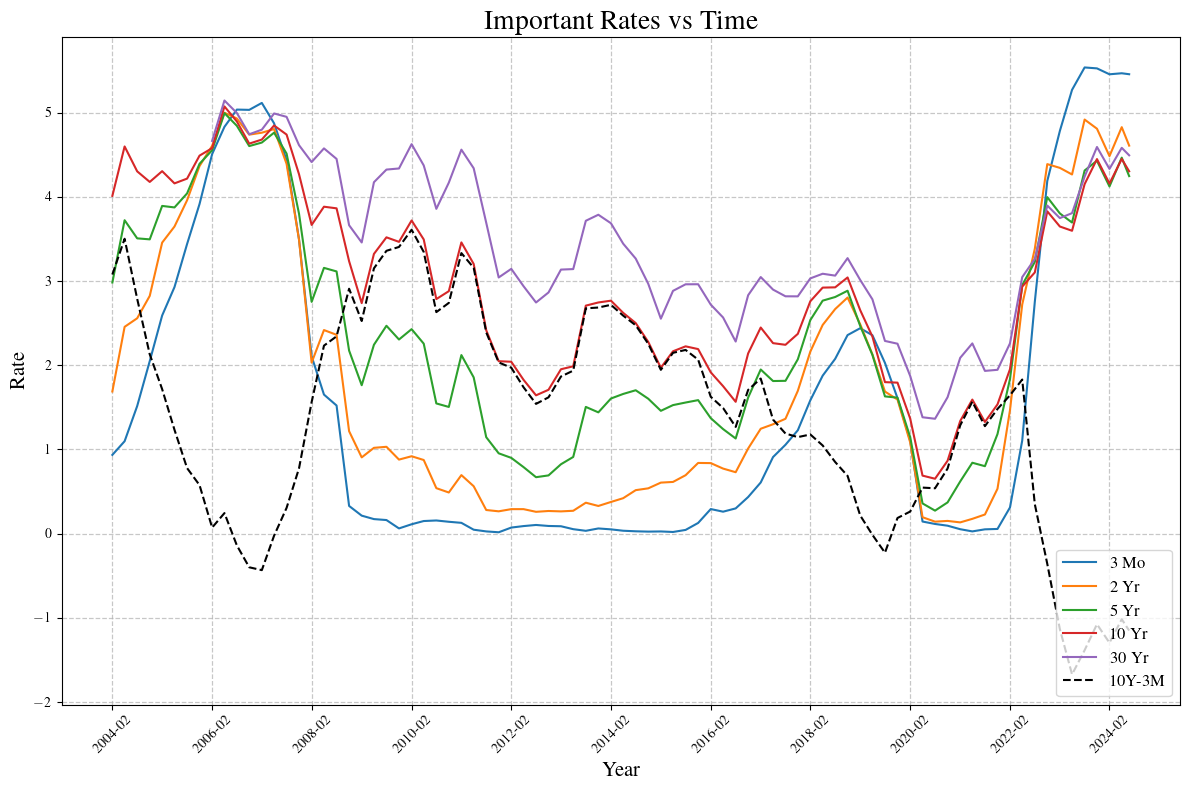

In [31]:
# Adjusting the figure size and creating a subplot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot fewer but more important rates
rates = ['3 Mo', '2 Yr', '5 Yr', '10 Yr', '30 Yr']
for rate in rates:
    ax.plot(finalrates['Date'], finalrates[rate], label=rate)

# Plot 10-year minus 3-month rate
ax.plot(finalrates['Date'], finalrates['10 Yr'] - finalrates['3 Mo'], label='10Y-3M', linestyle='--', color='black')

# Adding axis labels and customizing their font size
ax.set_xlabel('Year', fontsize=15, fontweight='bold')
ax.set_ylabel('Rate', fontsize=15, fontweight='bold')

# Adding a title
ax.set_title('Important Rates vs Time', fontsize=20, fontweight='bold')

# Adding a legend with customized position and font size
ax.legend(loc='lower right', fontsize=12)

# Rotating date labels for better readability
ax.set_xticks(finalrates['Date'][::len(finalrates['Date'])//10])  # Adjust tick frequency
ax.set_xticklabels([date.strftime('%Y-%m') for date in finalrates['Date'][::len(finalrates['Date'])//10]], rotation=45)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.9, alpha=0.7)

# Improving layout for tight fit
plt.tight_layout()

plt.show()

**Interpretation:** If the 10Y3M line dips below zero (goes negative), this indicates that the 3-month rate is higher than the 10-year rate, suggesting an inverted yield curve. This scenario is typically watched closely by economists and financial analysts as a potential sign of upcoming economic downturns. The other lines show how short-term and long-term interest rates have varied, providing insight into monetary policy impacts and market expectations.

### - Plot focusing on periods where the 10-year Treasury yield is less than the 3-month Treasury yield:

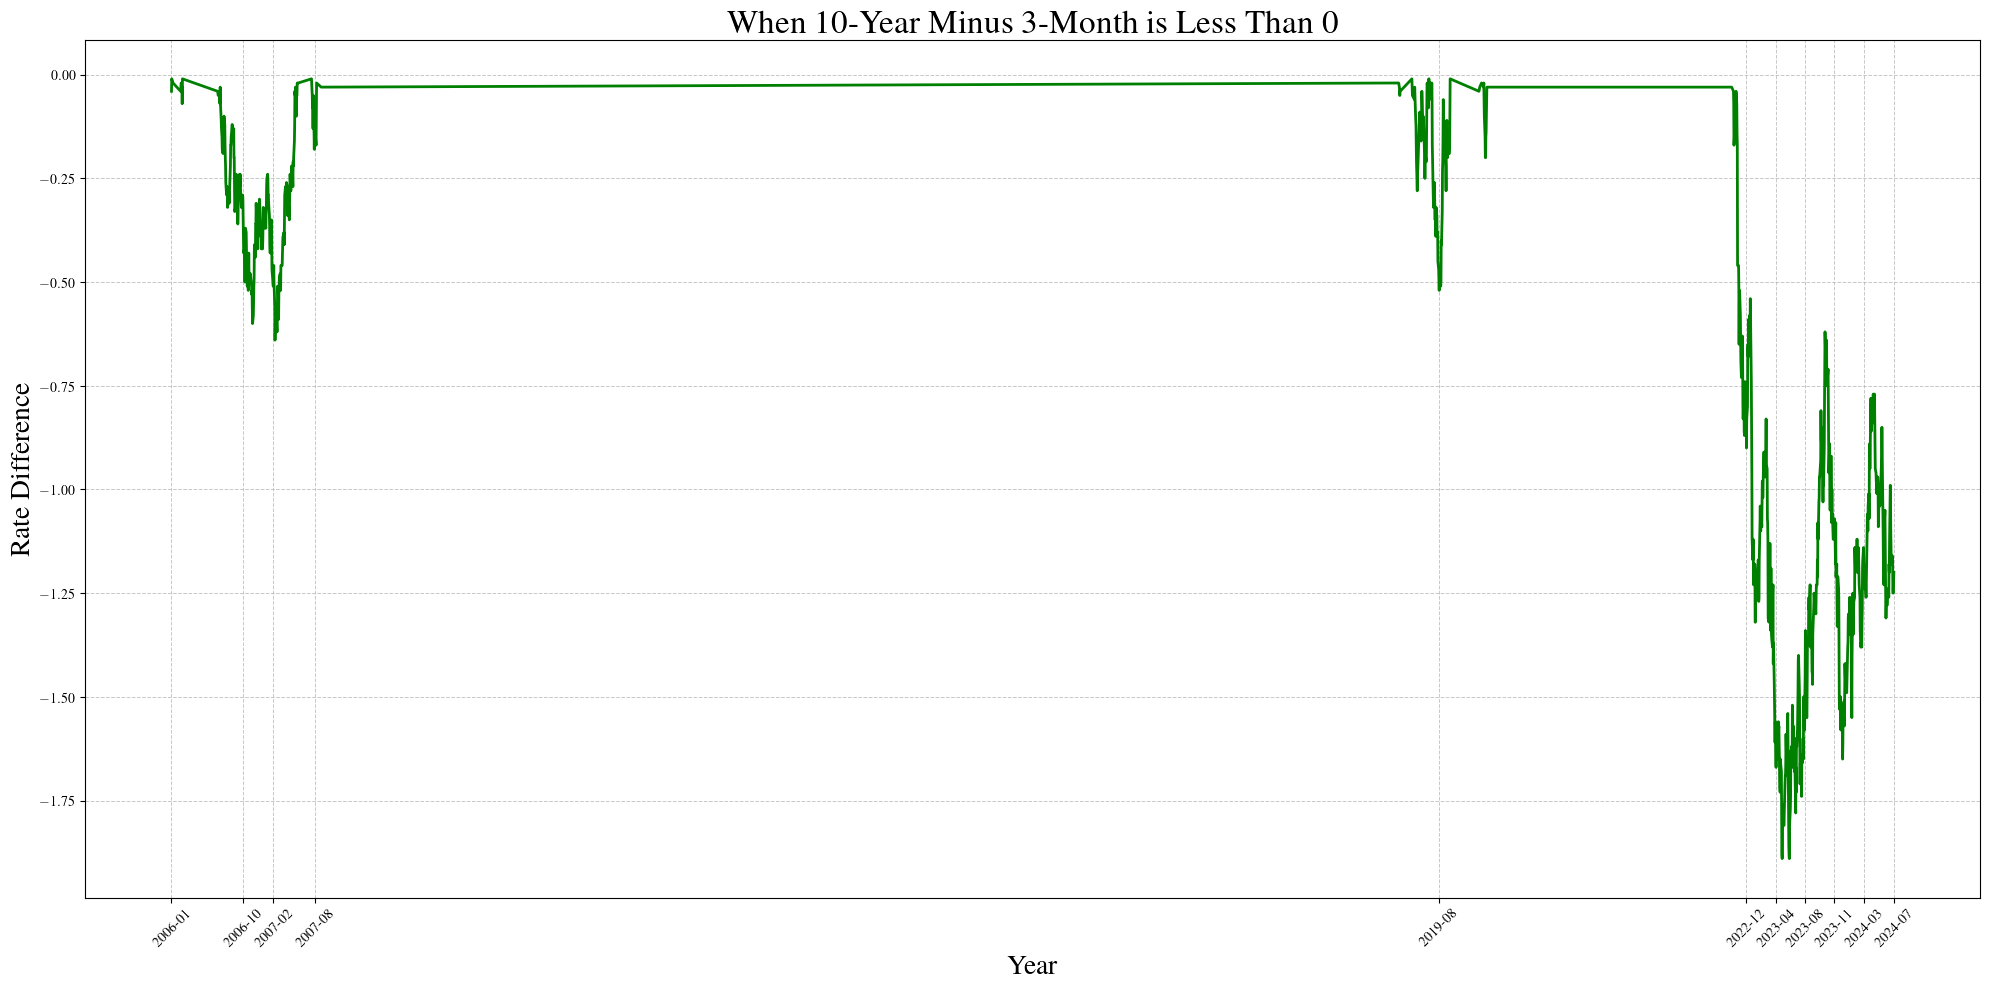

In [32]:
# Filter data where 10-year rate is less than 3-month rate
filtered_rates = rates_df[rates_df['10 Yr'] < rates_df['3 Mo']]

# Adjusting the figure size and creating a subplot
fig, ax = plt.subplots(figsize=(20, 10))

# Plotting the filtered data
ax.plot(filtered_rates['Date'], filtered_rates['10 Yr'] - filtered_rates['3 Mo'], color='green', linestyle='-', linewidth=2)

# Adding axis labels with customized font size
ax.set_xlabel('Year', fontsize=20, fontweight='bold')
ax.set_ylabel('Rate Difference', fontsize=20, fontweight='bold')

# Adding a title
ax.set_title('When 10-Year Minus 3-Month is Less Than 0', fontsize=24, fontweight='bold')

# Rotating date labels for better readability
ax.set_xticks(filtered_rates['Date'][::len(filtered_rates['Date'])//10])  # Adjust tick frequency
ax.set_xticklabels([date.strftime('%Y-%m') for date in filtered_rates['Date'][::len(filtered_rates['Date'])//10]], rotation=45)

# Adding gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improving layout for tight fit
plt.tight_layout()

plt.show()

**Interpretation:** The plot generated will display the periods when the 10-year Treasury yield is lower than the 3-month Treasury yield, indicating instances where the yield curve may be inverted.

#### Observations on Treasury Rates:

-  Trend of All Treasury Rates are similar.

-  Trends clearly show the periods of 2008 financial crisis, covid pandemic, and post-pandemic era.

-  Longer-term treasury rate are usually more than shorter-term treasury rate. For example, 10-Year rate is usually greater than 3-month rate, except a period before 2008, and the post-pandemic era.

### - Correlation Matrix:

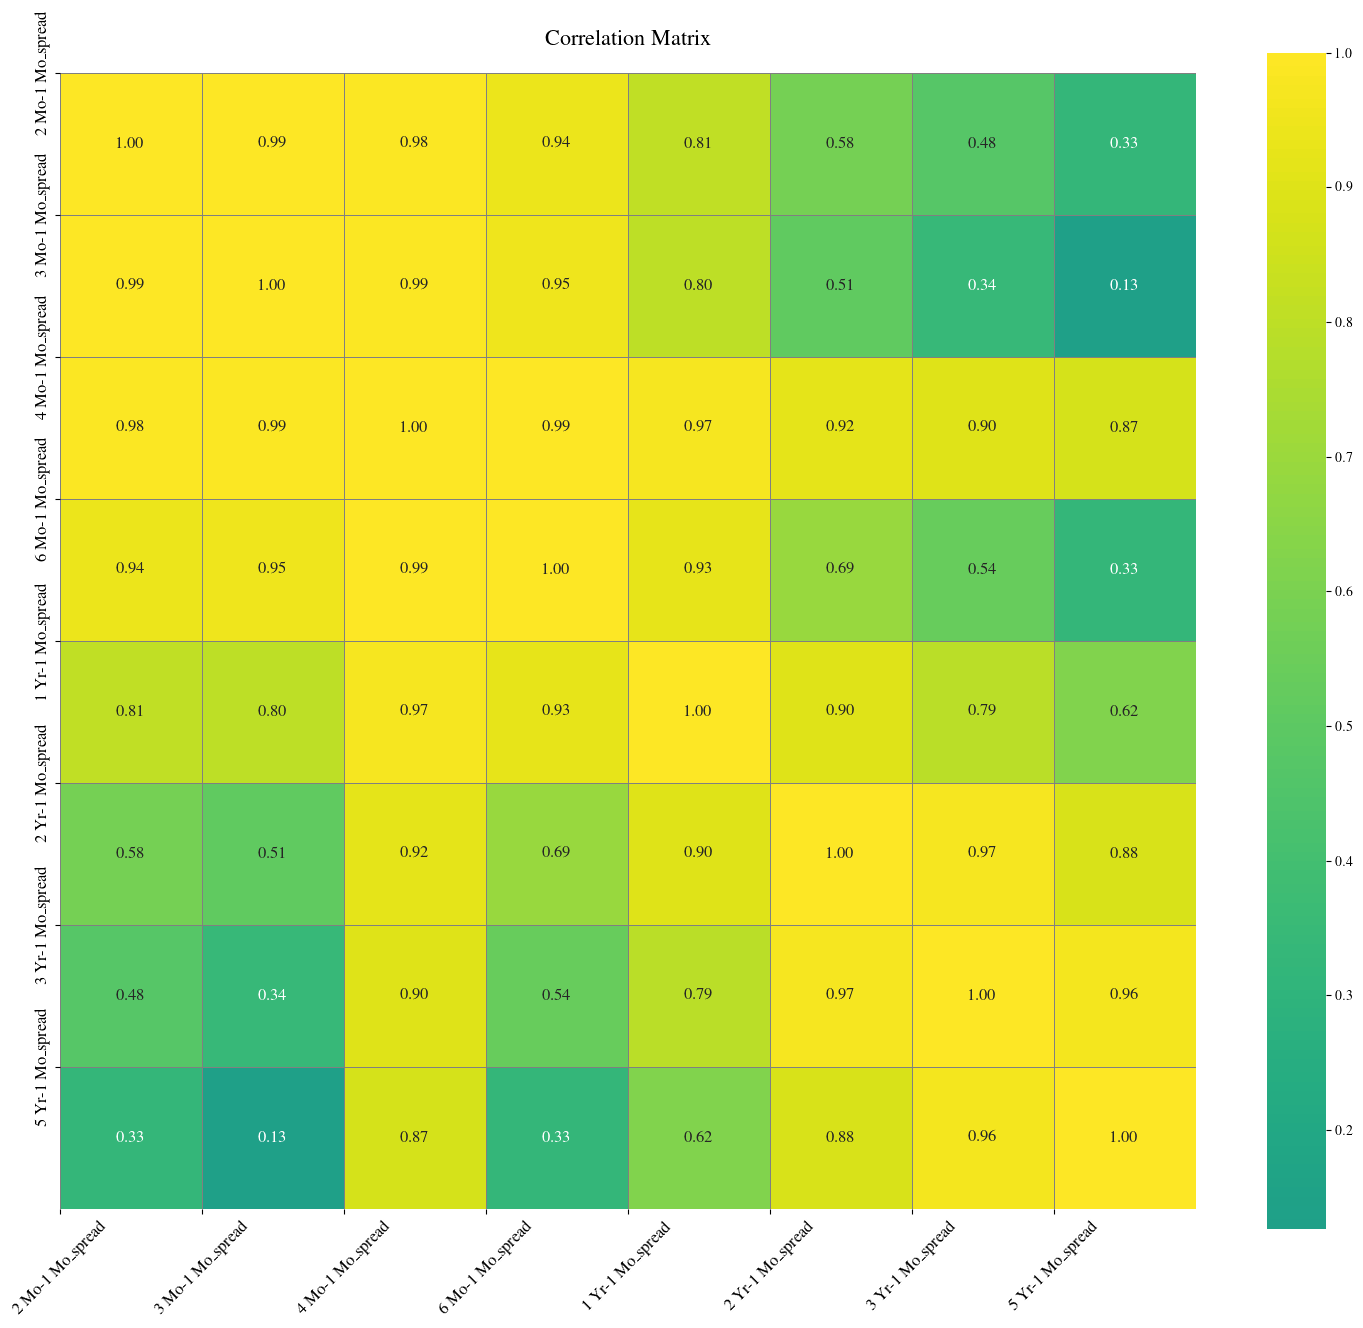

In [33]:
def plotCorrelationMatrix(df, graphWidth):
    # Compute the correlation matrix
    corr = df.corr()
    
    # Create a square figure with specified size
    plt.figure(figsize=(graphWidth, graphWidth))
    
    # Create the heatmap with refined aesthetics
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', center=0, 
                linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .8}, 
                square=True, annot_kws={"size": 12, "weight": 'bold'})
    
    # Customize ticks and labels
    plt.xticks(ticks=range(len(corr.columns)), labels=corr.columns, rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(corr.columns)), labels=corr.columns, fontsize=12)
    
    # Set title and labels
    plt.title('Correlation Matrix', fontsize=16, pad=20)
    
    # Adjust layout to ensure labels fit within the figure
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Usage
columns_to_consider = result_df.columns[2:10]
columns_to_include = [col for col in columns_to_consider]
df_selected = result_df[columns_to_include]
plotCorrelationMatrix(df_selected, 15)

### - Scatter and Density Plots

In [34]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    # keep only numerical columns
    df = df.select_dtypes(include =[np.number]) 
    columnNames = list(df)
    df = df[columnNames]
    #Create the frames
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

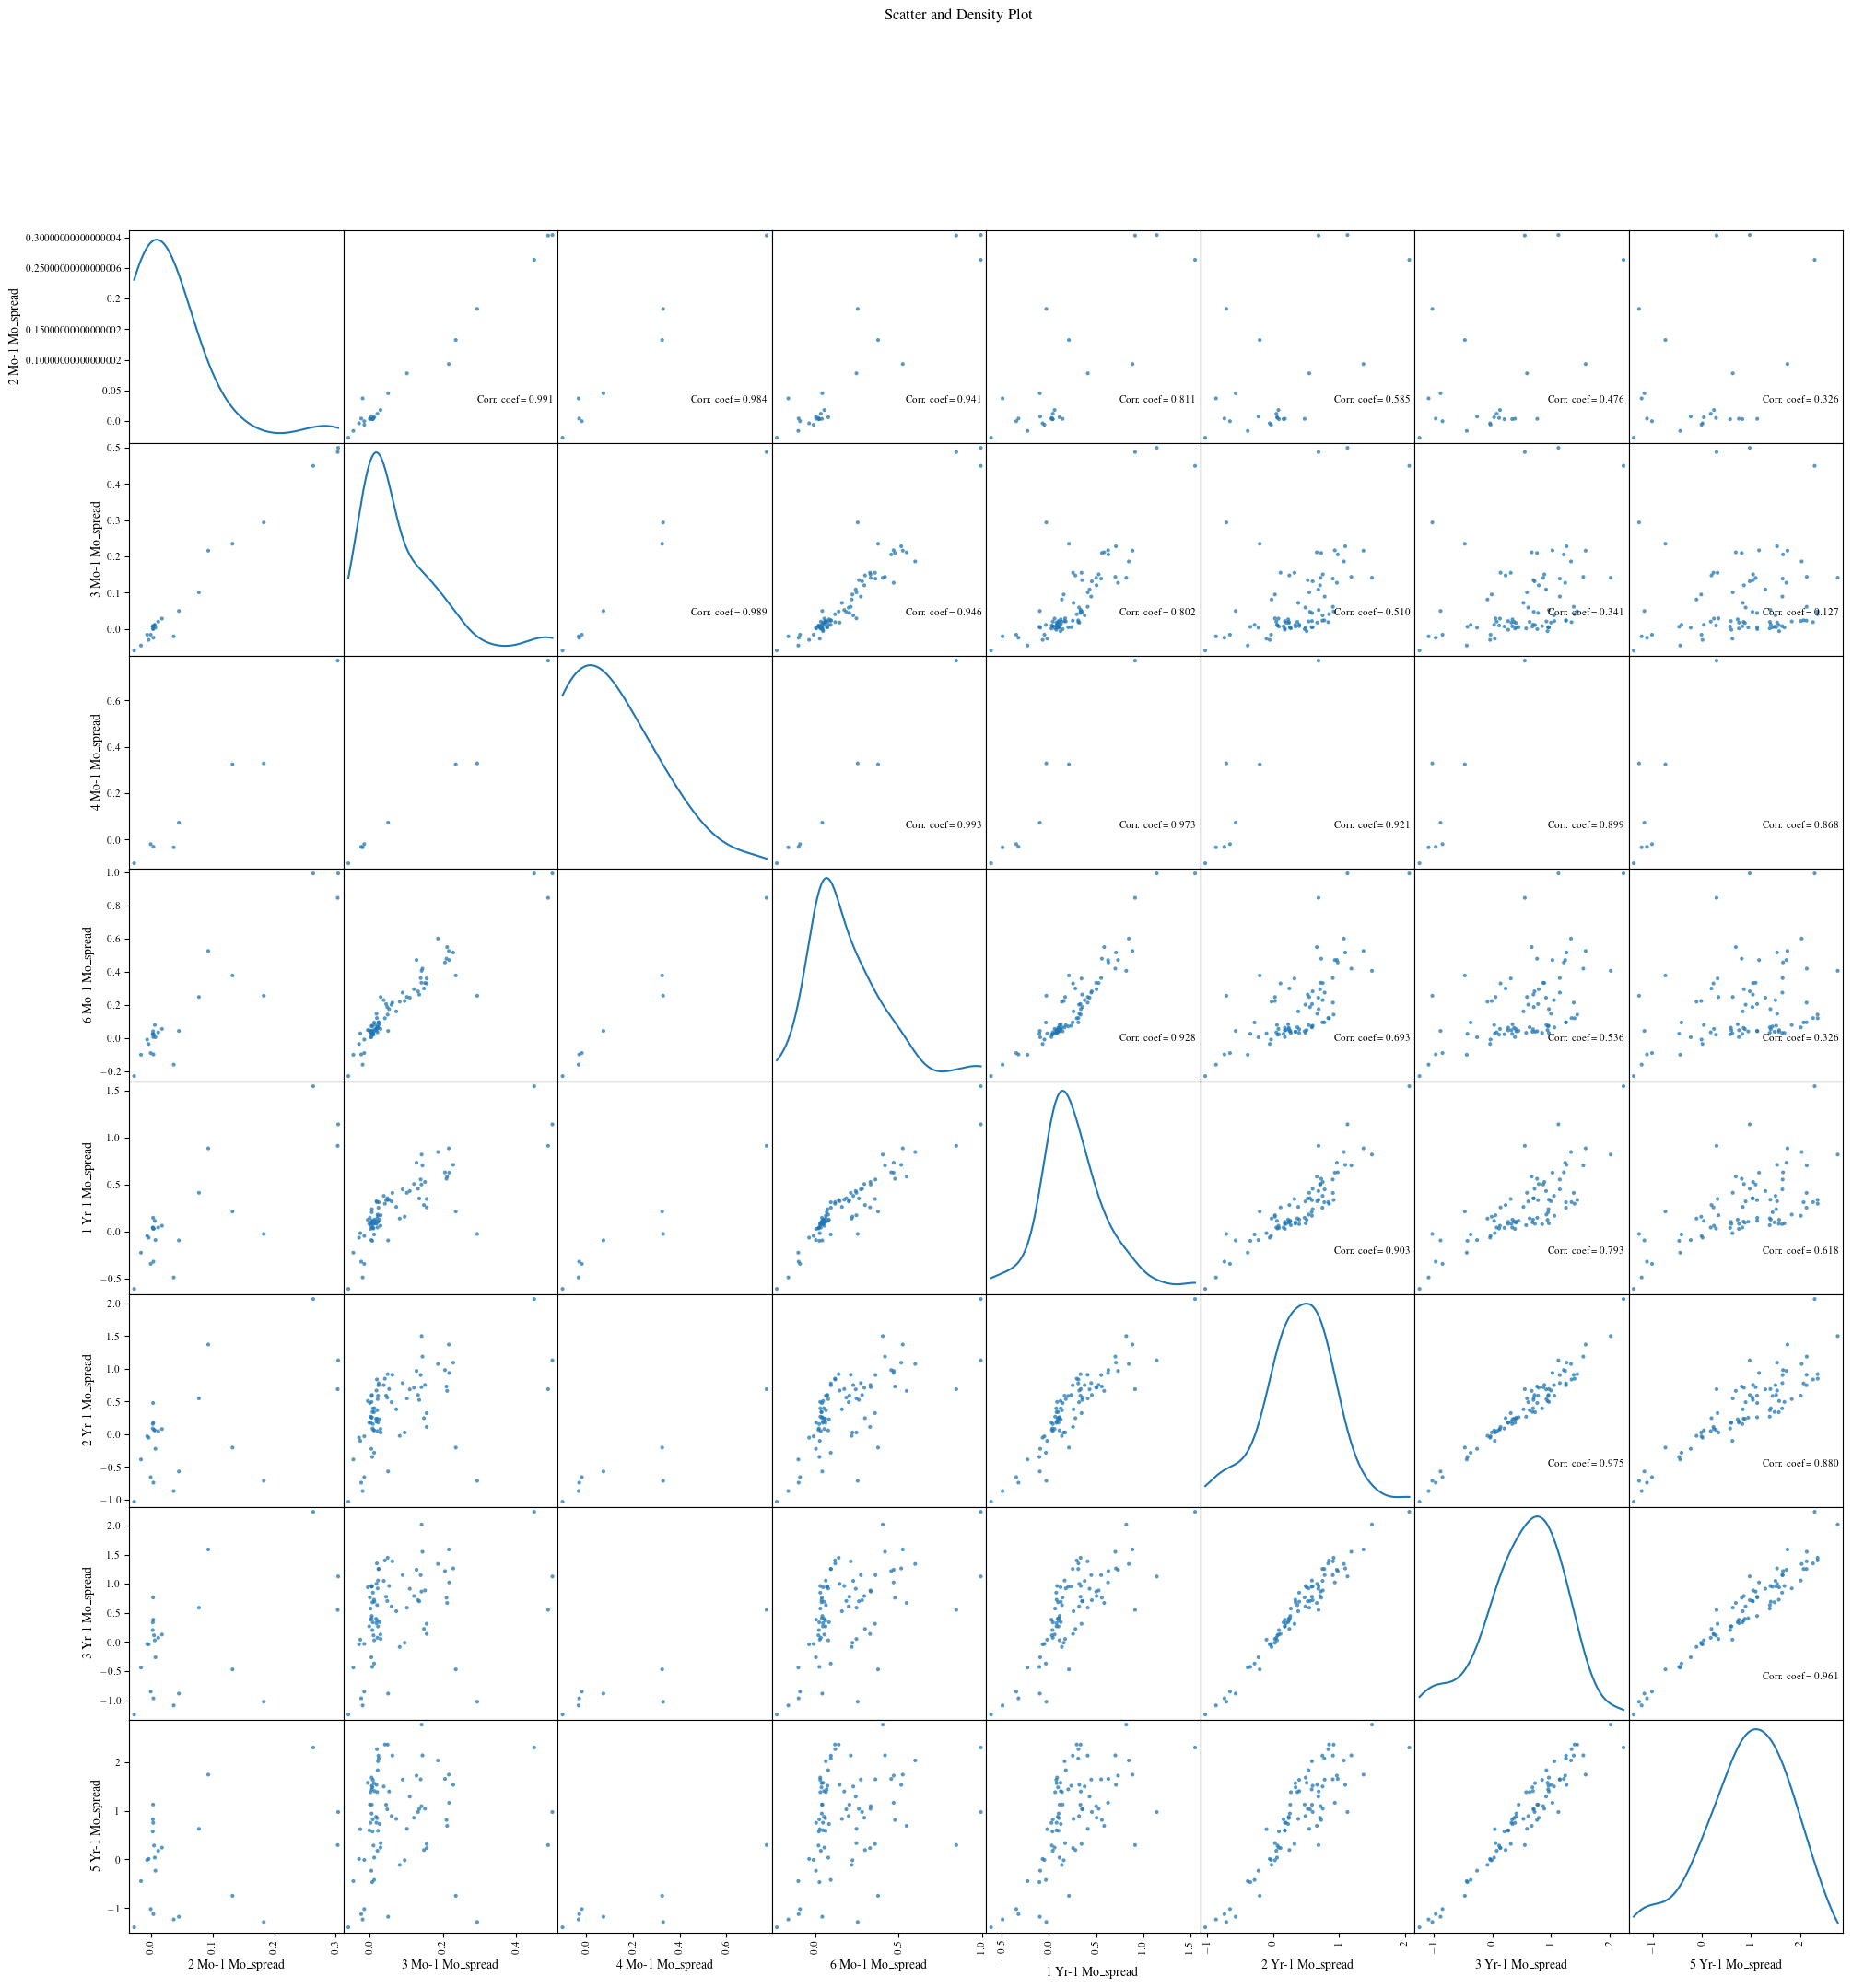

In [35]:
plotScatterMatrix(df_selected, 24, 8)

In [36]:
Spreads_df = result_df.copy()
Spreads_df.drop(columns=['Year', 'Quarter'], inplace=True)
Spreads_df.head()

,2 Mo-1 Mo_spread,3 Mo-1 Mo_spread,4 Mo-1 Mo_spread,6 Mo-1 Mo_spread,1 Yr-1 Mo_spread,2 Yr-1 Mo_spread,3 Yr-1 Mo_spread,5 Yr-1 Mo_spread,7 Yr-1 Mo_spread,10 Yr-1 Mo_spread,...,7 Yr-5 Yr_spread,10 Yr-5 Yr_spread,20 Yr-5 Yr_spread,30 Yr-5 Yr_spread,10 Yr-7 Yr_spread,20 Yr-7 Yr_spread,30 Yr-7 Yr_spread,20 Yr-10 Yr_spread,30 Yr-10 Yr_spread,30 Yr-20 Yr_spread
0,NaN,0.024032,NaN,0.093871,0.311774,0.776935,1.253387,2.071290,2.591774,3.100323,...,0.520484,1.029032,1.896935,NaN,0.508548,1.376452,NaN,0.867903,NaN,NaN
1,NaN,0.141613,NaN,0.405161,0.820968,1.500161,2.017419,2.766452,3.229355,3.642581,...,0.462903,0.876129,1.634677,NaN,0.413226,1.171774,NaN,0.758548,NaN,NaN
2,NaN,0.143906,NaN,0.418437,0.705000,1.186562,1.549531,2.135625,2.552188,2.931406,...,0.416562,0.795781,1.562656,NaN,0.379219,1.146094,NaN,0.766875,NaN,NaN
3,NaN,0.205645,NaN,0.455806,0.630968,0.980645,1.217097,1.651935,2.013226,2.334032,...,0.361290,0.682097,1.381129,NaN,0.320806,1.019839,NaN,0.699032,NaN,NaN
4,NaN,0.228197,NaN,0.515902,0.711475,1.093934,1.262951,1.529836,1.737869,1.942623,...,0.208033,0.412787,0.873279,NaN,0.204754,0.665246,NaN,0.460492,NaN,NaN


## 5. GDP, GDP Growth and Unemployment Dataset:

In [37]:
gdp_df = pd.read_csv(r"~/Desktop/Capstone Project/GDP.csv", parse_dates=True) ## GDP
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
print(gdp_df.shape)
gdp_df.head()

(309, 2)


,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [38]:
uner_df = pd.read_csv(r"~/Desktop/Capstone Project/UNRATE.csv") ## Unemployment Rate
uner_df['DATE'] = pd.to_datetime(uner_df['DATE'])
print(uner_df.shape)
uner_df.head()

(82, 2)


,DATE,UNRATE
0,2004-01-01,5.700000
1,2004-04-01,5.600000
2,2004-07-01,5.433333
3,2004-10-01,5.433333
4,2005-01-01,5.300000


In [39]:
gdp_growth = pd.read_csv(r"~/Desktop/Capstone Project/GDP_growth_2004-2024.csv")
gdp_growth['DATE'] = pd.to_datetime(gdp_growth['DATE'])
gdp_growth.head()

,DATE,GDP growth
0,2004-01-01,2.3
1,2004-04-01,3.1
2,2004-07-01,3.8
3,2004-10-01,4.1
4,2005-01-01,4.5


In [40]:
df_gdp_uner = pd.merge(gdp_df,uner_df,on='DATE')
print(df_gdp_uner.shape)
df_gdp_uner.head()

(81, 3)


,DATE,GDP,UNRATE
0,2004-01-01,11923.447,5.700000
1,2004-04-01,12112.815,5.600000
2,2004-07-01,12305.307,5.433333
3,2004-10-01,12527.214,5.433333
4,2005-01-01,12767.286,5.300000


In [41]:
df_gdp_uner = pd.merge(gdp_growth, df_gdp_uner, on = 'DATE')
print(df_gdp_uner.shape)
df_gdp_uner.head()

(81, 4)


,DATE,GDP growth,GDP,UNRATE
0,2004-01-01,2.3,11923.447,5.700000
1,2004-04-01,3.1,12112.815,5.600000
2,2004-07-01,3.8,12305.307,5.433333
3,2004-10-01,4.1,12527.214,5.433333
4,2005-01-01,4.5,12767.286,5.300000


In [42]:
df_gdp_uner['DATE'] = pd.to_datetime(df_gdp_uner['DATE'].astype(str), format='mixed', utc=True)
df_gdp_uner.head()

,DATE,GDP growth,GDP,UNRATE
0,2004-01-01 00:00:00+00:00,2.3,11923.447,5.700000
1,2004-04-01 00:00:00+00:00,3.1,12112.815,5.600000
2,2004-07-01 00:00:00+00:00,3.8,12305.307,5.433333
3,2004-10-01 00:00:00+00:00,4.1,12527.214,5.433333
4,2005-01-01 00:00:00+00:00,4.5,12767.286,5.300000


### -  Updating dates based on quarterly end dates and adjusting dates for December months: 

In [43]:
def update_quart_enddate_shift(df):
    # Define a dictionary to map the month to the new date
    quarter_end_dates = {1: (12, 31), 4: (3, 31), 7: (6, 30), 10: (9, 30)}

    # Apply the mapping to update the dates
    for month, (new_month, new_day) in quarter_end_dates.items():
        df.loc[df['DATE'].dt.month == month, 'DATE'] = df['DATE'].apply(
            lambda x: x.replace(month=new_month, day=new_day) if x.month == month else x
        )

    # offset the years by 1 for those whose month is december
    tmp_ids = df[df["DATE"].dt.month == 12].index
    df.loc[tmp_ids, "DATE"] = df.loc[tmp_ids, "DATE"] - pd.DateOffset(years=1)

    # drop the first row df_gdp_uner
    df.drop(df.index[0], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [44]:
df_gdp_uner =  update_quart_enddate_shift(df_gdp_uner)
df_gdp_uner.head()

,DATE,GDP growth,GDP,UNRATE
0,2004-03-31 00:00:00+00:00,3.1,12112.815,5.600000
1,2004-06-30 00:00:00+00:00,3.8,12305.307,5.433333
2,2004-09-30 00:00:00+00:00,4.1,12527.214,5.433333
3,2004-12-31 00:00:00+00:00,4.5,12767.286,5.300000
4,2005-03-31 00:00:00+00:00,2.0,12922.656,5.100000


In [45]:
name_dict = {'DATE':'Date',
             'GDP' : 'GDP',
             'UNRATE': 'UNRATE'}
df_gdp_uner = df_gdp_uner.rename(columns = name_dict)
df_gdp_uner.head()

,Date,GDP growth,GDP,UNRATE
0,2004-03-31 00:00:00+00:00,3.1,12112.815,5.600000
1,2004-06-30 00:00:00+00:00,3.8,12305.307,5.433333
2,2004-09-30 00:00:00+00:00,4.1,12527.214,5.433333
3,2004-12-31 00:00:00+00:00,4.5,12767.286,5.300000
4,2005-03-31 00:00:00+00:00,2.0,12922.656,5.100000


In [46]:
df_gdp_uner['Year'] = df_gdp_uner['Date'].dt.year
df_gdp_uner['Quarter'] = df_gdp_uner['Date'].dt.quarter
df_gdp_uner.head()

,Date,GDP growth,GDP,UNRATE,Year,Quarter
0,2004-03-31 00:00:00+00:00,3.1,12112.815,5.600000,2004,1
1,2004-06-30 00:00:00+00:00,3.8,12305.307,5.433333,2004,2
2,2004-09-30 00:00:00+00:00,4.1,12527.214,5.433333,2004,3
3,2004-12-31 00:00:00+00:00,4.5,12767.286,5.300000,2004,4
4,2005-03-31 00:00:00+00:00,2.0,12922.656,5.100000,2005,1


### - Visualization of Unemployment Rate over Time:

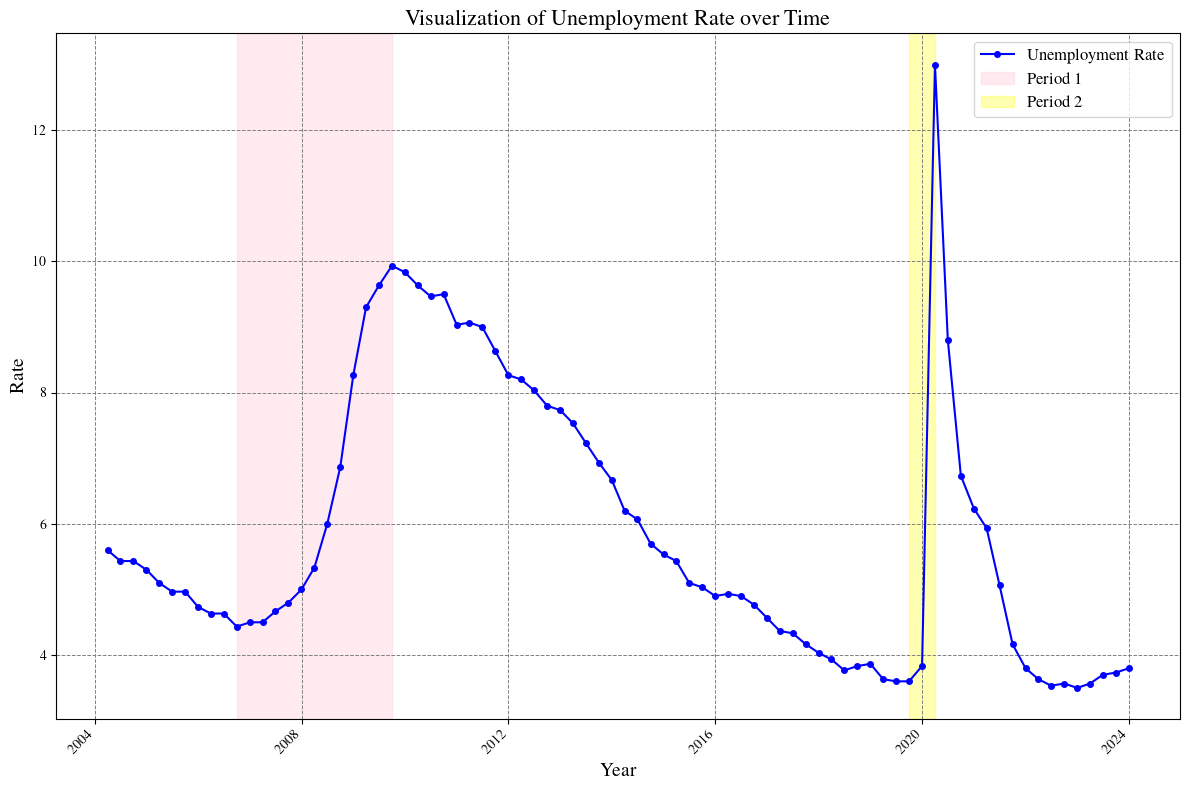

In [47]:
# Adjusting the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Creating the plot with a label for the legend
ax.plot(df_gdp_uner['Date'], df_gdp_uner['UNRATE'], label='Unemployment Rate', color='blue', linestyle='-', marker='o', markersize=4)

# Adding a plot title and customizing its font size and weight
ax.set_title('Visualization of Unemployment Rate over Time', fontsize=16, fontweight='bold')

# Adding axis labels and customizing their font size and weight
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Rate', fontsize=14, fontweight='bold')

# Highlighting the time period from 2006-09-30 to 2009-09-30
plt.axvspan(datetime(2006, 9, 30), datetime(2009, 9, 30), color='pink', alpha=0.3, label='Period 1')

# Highlighting the time period from 2019-09-30 to 2020-03-31
plt.axvspan(datetime(2019, 9, 30), datetime(2020, 3, 31), color='yellow', alpha=0.3, label='Period 2')

# Adding a legend to the plot with custom font size
ax.legend(fontsize=12)

# Adding grid lines with customized appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray')
# Rotating date labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding a tight layout to ensure no clipping of labels
plt.tight_layout()

plt.show()


### - Determine periods where GDP is decreasing:

In [48]:
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
gdp_df['Decrease'] = gdp_df['GDP'].diff().shift(-1) < 0
gdp_df.head()

,DATE,GDP,Decrease
0,1947-01-01,243.164,False
1,1947-04-01,245.968,False
2,1947-07-01,249.585,False
3,1947-10-01,259.745,False
4,1948-01-01,265.742,False


### - Plot of GDP data over time:

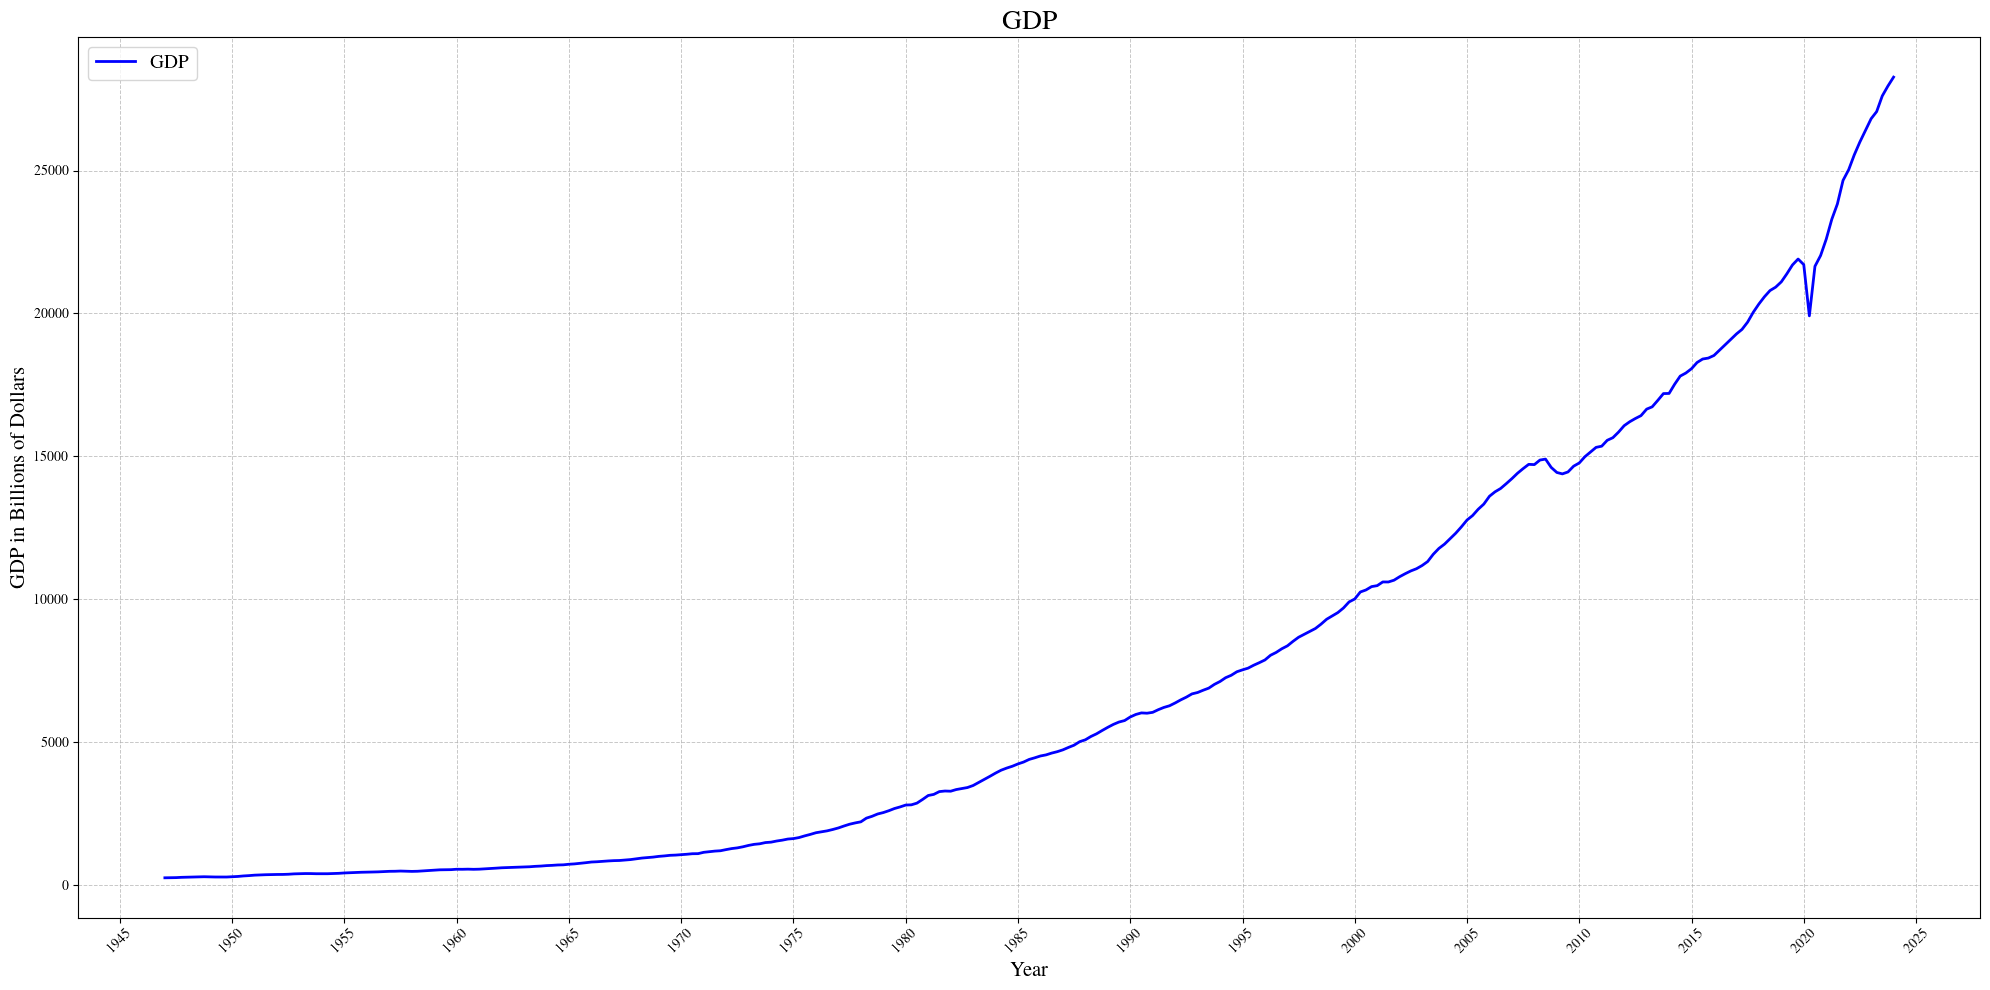

In [49]:
# Create a large figure
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the data with a customized line style and color
ax.plot(gdp_df['DATE'], gdp_df['GDP'], color='blue', linestyle='-', linewidth=2, label='GDP')

# Format the x-axis to show only the year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Label the axes and the title
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('GDP in Billions of Dollars', fontsize=15)
ax.set_title('GDP', fontsize=20)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add a legend
ax.legend(fontsize=14)

# Improve layout to ensure no overlaps
plt.tight_layout()

# Display the plot
plt.show()

### - GDP from the year 2000 onwards:

In [50]:
gdp_after2000 = gdp_df[gdp_df['DATE'] >= '2000-01-01']
gdp_after2000.head()

,DATE,GDP,Decrease
212,2000-01-01,10002.179,False
213,2000-04-01,10247.720,False
214,2000-07-01,10318.165,False
215,2000-10-01,10435.744,False
216,2001-01-01,10470.231,False


### - Visualizing GDP data after the year 2000, highlighting periods where GDP decreases:

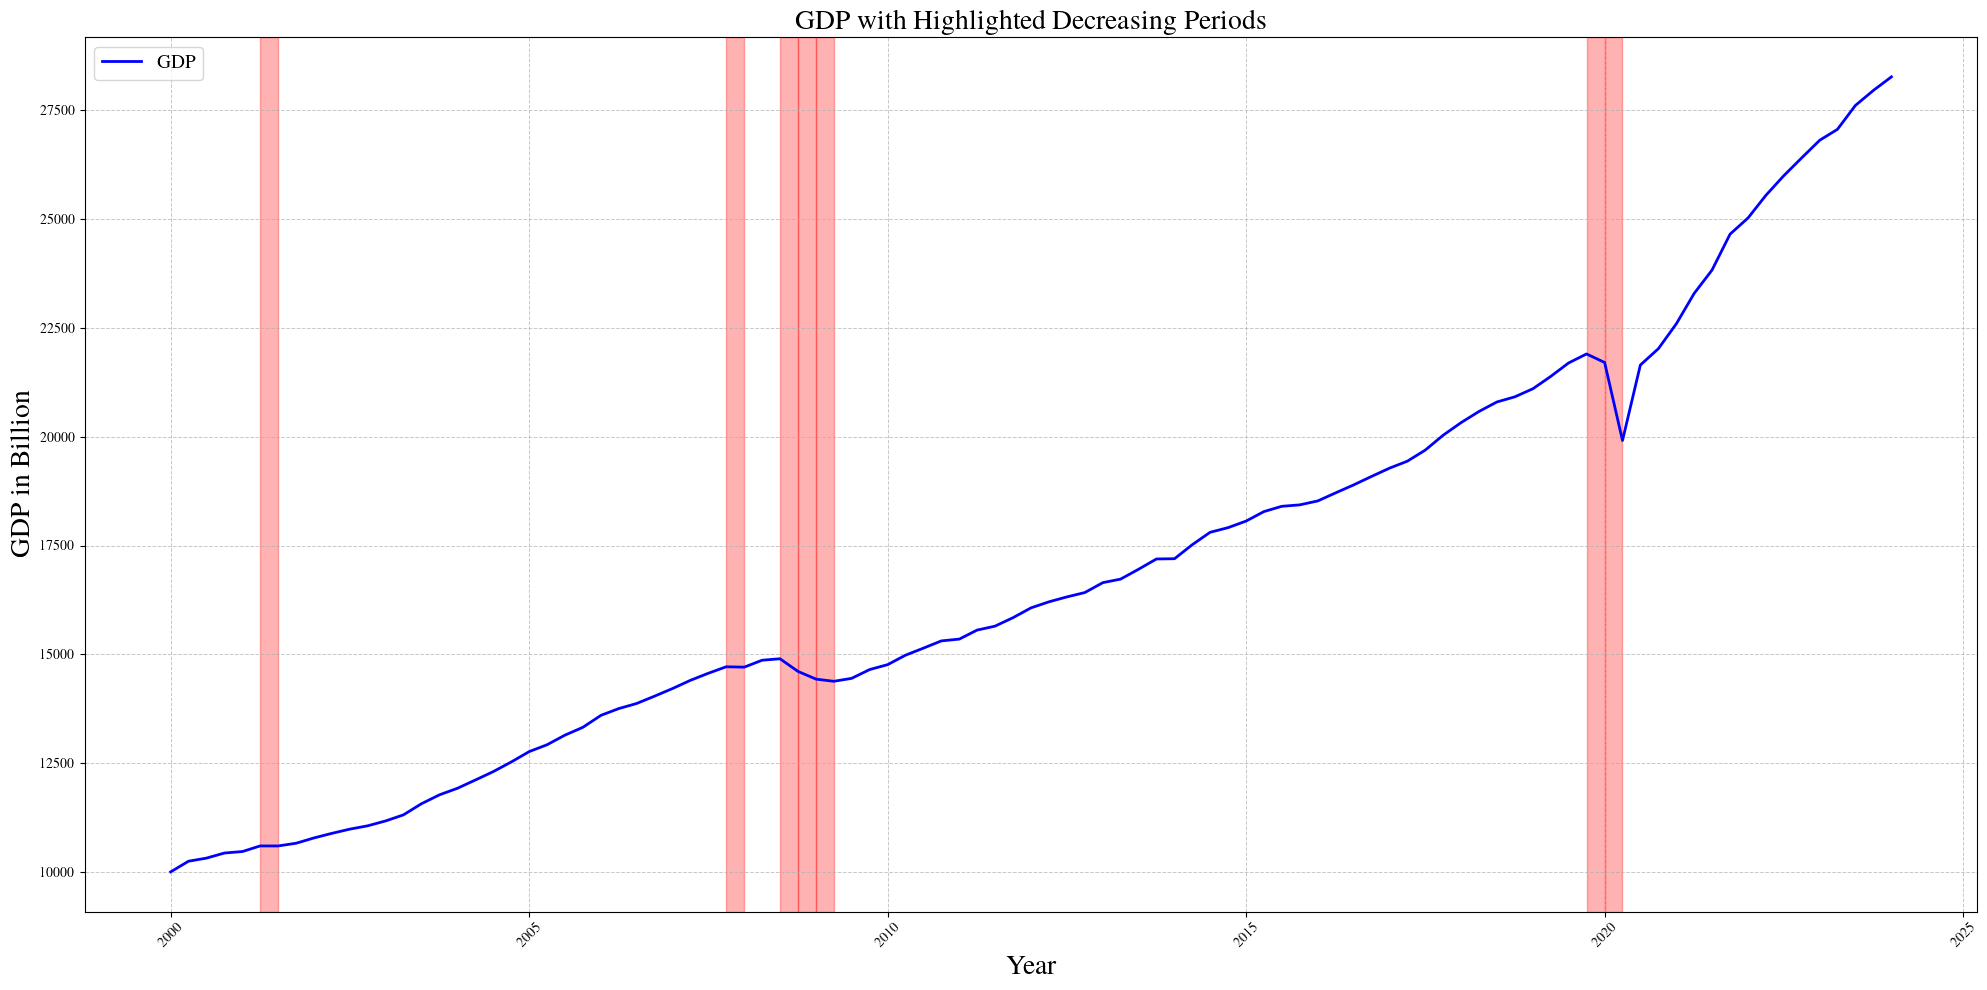

In [51]:
# Create a large figure
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the GDP data
ax.plot(gdp_after2000['DATE'], gdp_after2000['GDP'], color='blue', linestyle='-', linewidth=2, label='GDP')

# Format the x-axis to show only the year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))

# Highlight decreasing periods
for i in range(len(gdp_after2000) - 1):
    if gdp_after2000['Decrease'].iloc[i]:
        ax.axvspan(gdp_after2000['DATE'].iloc[i], gdp_after2000['DATE'].iloc[i + 1], color='red', alpha=0.3)

# Label the axes and the title
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('GDP in Billion', fontsize=20)
ax.set_title('GDP with Highlighted Decreasing Periods', fontsize=20)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend
ax.legend(fontsize=14)

# Improve layout to ensure no overlaps
plt.tight_layout()

# Display the plot
plt.show()

**Possible Reasons for GDP decrease:**

-  911 event
- 2008 crisis
- COVID pandemic

## 6. Combine Interest Rates, GDP and Unemployment Rates:

In [52]:
cmev = pd.concat([finalrates_df, Spreads_df, df_gdp_uner], axis = 1)
cmev.drop(columns=['Year', 'Quarter'], inplace=True)
cmev.head()

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,...,10 Yr-7 Yr_spread,20 Yr-7 Yr_spread,30 Yr-7 Yr_spread,20 Yr-10 Yr_spread,30 Yr-10 Yr_spread,30 Yr-20 Yr_spread,Date,GDP growth,GDP,UNRATE
0,0.909677,NaN,0.933710,NaN,1.003548,1.221452,1.686613,2.163065,2.980968,3.501452,...,0.508548,1.376452,NaN,0.867903,NaN,NaN,2004-03-31 00:00:00+00:00,3.1,12112.815,5.600000
1,0.954516,NaN,1.096129,NaN,1.359677,1.775484,2.454677,2.971935,3.720968,4.183871,...,0.413226,1.171774,NaN,0.758548,NaN,NaN,2004-06-30 00:00:00+00:00,3.8,12305.307,5.433333
2,1.370000,NaN,1.513906,NaN,1.788437,2.075000,2.556563,2.919531,3.505625,3.922188,...,0.379219,1.146094,NaN,0.766875,NaN,NaN,2004-09-30 00:00:00+00:00,4.1,12527.214,5.433333
3,1.841774,NaN,2.047419,NaN,2.297581,2.472742,2.822419,3.058871,3.493710,3.855000,...,0.320806,1.019839,NaN,0.699032,NaN,NaN,2004-12-31 00:00:00+00:00,4.5,12767.286,5.300000
4,2.360984,NaN,2.589180,NaN,2.876885,3.072459,3.454918,3.623934,3.890820,4.098852,...,0.204754,0.665246,NaN,0.460492,NaN,NaN,2005-03-31 00:00:00+00:00,2.0,12922.656,5.100000


In [53]:
cmev.shape

(83, 95)

## 7. Combine Fincial Dataset with the Macroeconomic variables:

In [54]:
Quarterized_dfs.head()

,RSSD ID,Start Date,Firm Legal Name,FR District Code,Bank Count,Reporting Date,Total Assets,Interest Income Year-to-Date,Interest Expense,Net Interest Income,Non-Interest Income Year-to-Date,Non-Interest Expense,Quarter,Year,Interest Income per Quarter,Normalized Interest Income per Quarter
0,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-03-31 00:00:00+00:00,11959875.0,108983.0,15686.0,93297.0,30819.0,79566.0,1,2018,108983.0,0.009112
1,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-06-30 00:00:00+00:00,12077601.0,224623.0,36271.0,188352.0,60958.0,159789.0,2,2018,115640.0,0.009575
2,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-09-30 00:00:00+00:00,12119987.0,342266.0,58552.0,283714.0,91838.0,239242.0,3,2018,117643.0,0.009707
3,1020180,2015-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,1.0,2018-12-31 00:00:00+00:00,12192038.0,462684.0,83107.0,379577.0,124334.0,325762.0,4,2018,120418.0,0.009877
4,1020180,2005-12-31 00:00:00+00:00,BREMER FINANCIAL CORPORATION,9,9.0,2006-03-31 00:00:00+00:00,6480680.0,100170.0,43216.0,56954.0,18200.0,47328.0,1,2006,100170.0,0.015457


In [55]:
Quarterized_dfs.shape

(243757, 16)

In [56]:
# selecting some columns of Quater
small_Quaterized_dfs = Quarterized_dfs[['RSSD ID', 'Firm Legal Name', 'FR District Code', 'Total Assets', 'Reporting Date', 'Year', 'Quarter',
                                        'Normalized Interest Income per Quarter']]
small_Quaterized_dfs.head()

,RSSD ID,Firm Legal Name,FR District Code,Total Assets,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter
0,1020180,BREMER FINANCIAL CORPORATION,9,11959875.0,2018-03-31 00:00:00+00:00,2018,1,0.009112
1,1020180,BREMER FINANCIAL CORPORATION,9,12077601.0,2018-06-30 00:00:00+00:00,2018,2,0.009575
2,1020180,BREMER FINANCIAL CORPORATION,9,12119987.0,2018-09-30 00:00:00+00:00,2018,3,0.009707
3,1020180,BREMER FINANCIAL CORPORATION,9,12192038.0,2018-12-31 00:00:00+00:00,2018,4,0.009877
4,1020180,BREMER FINANCIAL CORPORATION,9,6480680.0,2006-03-31 00:00:00+00:00,2006,1,0.015457


In [57]:
# Ensure you're modifying the DataFrame in a safe way
small_Quaterized_dfs.loc[:, 'Reporting Date'] = small_Quaterized_dfs['Reporting Date'].dt.tz_localize(None).astype('datetime64[ns]')
cmev.loc[:, 'Date'] = cmev['Date'].dt.tz_localize(None).astype('datetime64[ns]')

# Merge the DataFrames
df = small_Quaterized_dfs.merge(cmev, left_on='Reporting Date', right_on='Date', how='left')
df.drop(columns=['Date'], inplace=True)

df.head()

/var/folders/17/ccsw1mtx15qbwr2srhysxqt80000gn/T/ipykernel_10736/3249878014.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2018-03-31 00:00:00', '2018-06-30 00:00:00', '2018-09-30 00:00:00',
 '2018-12-31 00:00:00', '2006-03-31 00:00:00', '2006-06-30 00:00:00',
 '2006-09-30 00:00:00', '2006-12-31 00:00:00', '2009-03-31 00:00:00',
 '2009-06-30 00:00:00',
 ...
 '2023-12-31 00:00:00', '2023-12-31 00:00:00', '2024-03-31 00:00:00',
 '2023-12-31 00:00:00', '2023-12-31 00:00:00', '2023-12-31 00:00:00',
 '2023-12-31 00:00:00', '2024-03-31 00:00:00', '2023-12-31 00:00:00',
 '2023-12-31 00:00:00']
Length: 243757, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  small_Quaterized_dfs.loc[:, 'Reporting Date'] = small_Quaterized_dfs['Reporting Date'].dt.tz_localize(None).astype('datetime64[ns]')
/var/folders/17/ccsw1mtx15qbwr2srhys

,RSSD ID,Firm Legal Name,FR District Code,Total Assets,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,1 Mo,2 Mo,...,30 Yr-5 Yr_spread,10 Yr-7 Yr_spread,20 Yr-7 Yr_spread,30 Yr-7 Yr_spread,20 Yr-10 Yr_spread,30 Yr-10 Yr_spread,30 Yr-20 Yr_spread,GDP growth,GDP,UNRATE
0,1020180,BREMER FINANCIAL CORPORATION,9,11959875.0,2018-03-31,2018,1,0.009112,1.440984,NaN,...,0.495246,0.074590,0.220656,0.346230,0.146066,0.271639,0.125574,2.1,20580.912,3.933333
1,1020180,BREMER FINANCIAL CORPORATION,9,12077601.0,2018-06-30,2018,2,0.009575,1.723906,NaN,...,0.319688,0.046562,0.123125,0.211250,0.076563,0.164688,0.088125,2.5,20798.730,3.766667
2,1020180,BREMER FINANCIAL CORPORATION,9,12119987.0,2018-09-30,2018,3,0.009707,1.953968,NaN,...,0.253968,0.041587,0.114127,0.180794,0.072540,0.139206,0.066667,0.6,20917.867,3.833333
3,1020180,BREMER FINANCIAL CORPORATION,9,12192038.0,2018-12-31,2018,4,0.009877,2.255410,2.333333,...,0.387049,0.074590,0.210000,0.304098,0.135410,0.229508,0.094098,2.2,21104.133,3.866667
4,1020180,BREMER FINANCIAL CORPORATION,9,6480680.0,2006-03-31,2006,1,0.015457,4.358710,NaN,...,0.110636,0.021613,0.218548,0.107572,0.196935,0.085959,-0.110977,1.0,13753.424,4.633333


In [58]:
df.shape

(243757, 102)

### - Drop and Fill NA values:

In [59]:
#pd.set_option('display.max_rows', None)
df.isnull().sum().sort_values()

RSSD ID                   0
Firm Legal Name           0
FR District Code          0
Reporting Date            0
Year                      0
                      ...  
7 Yr-4 Mo_spread     231244
10 Yr-4 Mo_spread    231244
20 Yr-4 Mo_spread    231244
30 Yr-4 Mo_spread    231244
4 Mo-3 Mo_spread     231244
Length: 102, dtype: int64

In [60]:
# Extract the 'Normalized Interest Income per Quarter' column
normalized_income = df['Normalized Interest Income per Quarter']

# Fill missing values with the mean of the column for income
normalized_income_filled = normalized_income.fillna(normalized_income.mean())

# Update the original DataFrame
df['Normalized Interest Income per Quarter'] = normalized_income_filled

In [61]:
# Display the number of missing values per column
missing_values = df.isnull().sum()

# Sort the columns by the number of missing values (ascending order)
sorted_missing_values = missing_values.sort_values()

# Filter the DataFrame to include only columns with fewer missing values (e.g., less than a threshold)
# Set a threshold for maximum allowed missing values (e.g., 500)
threshold = 500
filtered_columns = sorted_missing_values[sorted_missing_values <= threshold].index

# Create a new DataFrame with the filtered columns
df0 = df[filtered_columns].dropna()
df0.head()

,RSSD ID,Firm Legal Name,FR District Code,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,3 Yr-1 Yr_spread,2 Yr-1 Yr_spread,20 Yr-6 Mo_spread,...,5 Yr,3 Yr,2 Yr,1 Yr,6 Mo,3 Mo,1 Mo,7 Yr,20 Yr-1 Mo_spread,UNRATE
0,1020180,BREMER FINANCIAL CORPORATION,9,2018-03-31,2018,1,0.009112,0.364262,0.218033,1.130656,...,2.534918,2.306721,2.160492,1.942459,1.773934,1.582131,1.440984,2.683934,1.463607,3.933333
1,1020180,BREMER FINANCIAL CORPORATION,9,2018-06-30,2018,2,0.009575,0.356875,0.224844,0.941875,...,2.765625,2.609062,2.477031,2.252187,2.055312,1.874688,1.723906,2.874062,1.273281,3.766667
2,1020180,BREMER FINANCIAL CORPORATION,9,2018-09-30,2018,3,0.009707,0.283333,0.205714,0.748095,...,2.809048,2.743492,2.665873,2.460159,2.248254,2.074603,1.953968,2.882222,1.042381,3.833333
3,1020180,BREMER FINANCIAL CORPORATION,9,2018-12-31,2018,4,0.009877,0.176066,0.134590,0.673770,...,2.883607,2.844262,2.802787,2.668197,2.502787,2.356721,2.255410,2.966557,0.921148,3.866667
4,1020180,BREMER FINANCIAL CORPORATION,9,2006-03-31,2006,1,0.015457,-0.057742,-0.035645,0.116774,...,4.552419,4.582581,4.604677,4.640323,4.657258,4.506613,4.358710,4.555484,0.415323,4.633333


In [62]:
df0.isnull().sum()

RSSD ID              0
Firm Legal Name      0
FR District Code     0
Reporting Date       0
Year                 0
                    ..
3 Mo                 0
1 Mo                 0
7 Yr                 0
20 Yr-1 Mo_spread    0
UNRATE               0
Length: 65, dtype: int64

In [63]:
# Making Lagged Variable for Normalized Interest Income
new_dfs = []
for i in df0['RSSD ID'].unique():
  new_df_i = df0.loc[df0['RSSD ID']==i,:]
  new_df_i = new_df_i.sort_values(['Year', 'Quarter'])
  new_df_i["Lagged Income"] = new_df_i['Normalized Interest Income per Quarter'].shift(1)
  new_dfs.append(new_df_i)

df_lag = pd.concat(new_dfs, ignore_index=True)
df_lag.head()

,RSSD ID,Firm Legal Name,FR District Code,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,3 Yr-1 Yr_spread,2 Yr-1 Yr_spread,20 Yr-6 Mo_spread,...,3 Yr,2 Yr,1 Yr,6 Mo,3 Mo,1 Mo,7 Yr,20 Yr-1 Mo_spread,UNRATE,Lagged Income
0,1020180,BREMER FINANCIAL CORPORATION,9,2004-03-31,2004,1,0.011926,0.941613,0.465161,3.874355,...,2.163065,1.686613,1.221452,1.003548,0.933710,0.909677,3.501452,3.968226,5.600000,NaN
1,1020180,BREMER FINANCIAL CORPORATION,9,2004-06-30,2004,2,0.011899,1.196452,0.679194,3.995968,...,2.971935,2.454677,1.775484,1.359677,1.096129,0.954516,4.183871,4.401129,5.433333,0.011926
2,1020180,BREMER FINANCIAL CORPORATION,9,2004-09-30,2004,3,0.012476,0.844531,0.481562,3.279844,...,2.919531,2.556563,2.075000,1.788437,1.513906,1.370000,3.922188,3.698281,5.433333,0.011899
3,1020180,BREMER FINANCIAL CORPORATION,9,2004-12-31,2004,4,0.012933,0.586129,0.349677,2.577258,...,3.058871,2.822419,2.472742,2.297581,2.047419,1.841774,3.855000,3.033065,5.300000,0.012476
4,1020180,BREMER FINANCIAL CORPORATION,9,2005-03-31,2005,1,0.013106,0.551475,0.382459,1.887213,...,3.623934,3.454918,3.072459,2.876885,2.589180,2.360984,4.098852,2.403115,5.100000,0.012933


In [64]:
df_lag.isnull().sum()

RSSD ID                 0
Firm Legal Name         0
FR District Code        0
Reporting Date          0
Year                    0
                     ... 
1 Mo                    0
7 Yr                    0
20 Yr-1 Mo_spread       0
UNRATE                  0
Lagged Income        8048
Length: 66, dtype: int64

In [65]:
df_lag = df_lag.dropna()
df_lag.head()

,RSSD ID,Firm Legal Name,FR District Code,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,3 Yr-1 Yr_spread,2 Yr-1 Yr_spread,20 Yr-6 Mo_spread,...,3 Yr,2 Yr,1 Yr,6 Mo,3 Mo,1 Mo,7 Yr,20 Yr-1 Mo_spread,UNRATE,Lagged Income
1,1020180,BREMER FINANCIAL CORPORATION,9,2004-06-30,2004,2,0.011899,1.196452,0.679194,3.995968,...,2.971935,2.454677,1.775484,1.359677,1.096129,0.954516,4.183871,4.401129,5.433333,0.011926
2,1020180,BREMER FINANCIAL CORPORATION,9,2004-09-30,2004,3,0.012476,0.844531,0.481562,3.279844,...,2.919531,2.556563,2.075000,1.788437,1.513906,1.370000,3.922188,3.698281,5.433333,0.011899
3,1020180,BREMER FINANCIAL CORPORATION,9,2004-12-31,2004,4,0.012933,0.586129,0.349677,2.577258,...,3.058871,2.822419,2.472742,2.297581,2.047419,1.841774,3.855000,3.033065,5.300000,0.012476
4,1020180,BREMER FINANCIAL CORPORATION,9,2005-03-31,2005,1,0.013106,0.551475,0.382459,1.887213,...,3.623934,3.454918,3.072459,2.876885,2.589180,2.360984,4.098852,2.403115,5.100000,0.012933
5,1020180,BREMER FINANCIAL CORPORATION,9,2005-06-30,2005,2,0.013722,0.395000,0.308594,1.369063,...,3.732344,3.645938,3.337344,3.179688,2.926719,2.709687,3.984688,1.839063,4.966667,0.013106


In [66]:
df_lag.shape

(235236, 66)

## 8. Model:

### - AR Model:

In [67]:
df1 = df_lag.copy()
df1 = df1.dropna()
df1.head()

,RSSD ID,Firm Legal Name,FR District Code,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,3 Yr-1 Yr_spread,2 Yr-1 Yr_spread,20 Yr-6 Mo_spread,...,3 Yr,2 Yr,1 Yr,6 Mo,3 Mo,1 Mo,7 Yr,20 Yr-1 Mo_spread,UNRATE,Lagged Income
1,1020180,BREMER FINANCIAL CORPORATION,9,2004-06-30,2004,2,0.011899,1.196452,0.679194,3.995968,...,2.971935,2.454677,1.775484,1.359677,1.096129,0.954516,4.183871,4.401129,5.433333,0.011926
2,1020180,BREMER FINANCIAL CORPORATION,9,2004-09-30,2004,3,0.012476,0.844531,0.481562,3.279844,...,2.919531,2.556563,2.075000,1.788437,1.513906,1.370000,3.922188,3.698281,5.433333,0.011899
3,1020180,BREMER FINANCIAL CORPORATION,9,2004-12-31,2004,4,0.012933,0.586129,0.349677,2.577258,...,3.058871,2.822419,2.472742,2.297581,2.047419,1.841774,3.855000,3.033065,5.300000,0.012476
4,1020180,BREMER FINANCIAL CORPORATION,9,2005-03-31,2005,1,0.013106,0.551475,0.382459,1.887213,...,3.623934,3.454918,3.072459,2.876885,2.589180,2.360984,4.098852,2.403115,5.100000,0.012933
5,1020180,BREMER FINANCIAL CORPORATION,9,2005-06-30,2005,2,0.013722,0.395000,0.308594,1.369063,...,3.732344,3.645938,3.337344,3.179688,2.926719,2.709687,3.984688,1.839063,4.966667,0.013106


In [68]:
# Sort the DataFrame by 'Reporting Date'
df1.sort_values(by='Reporting Date', inplace=True)

# Set 'Reporting Date' as the index
df1.set_index('Reporting Date', inplace=True)

#### Normalized Interest Income per Quarter:

In [69]:
# Select the column of interest
interest_income_series = df1['Normalized Interest Income per Quarter']
interest_income_series.shape

(235236,)

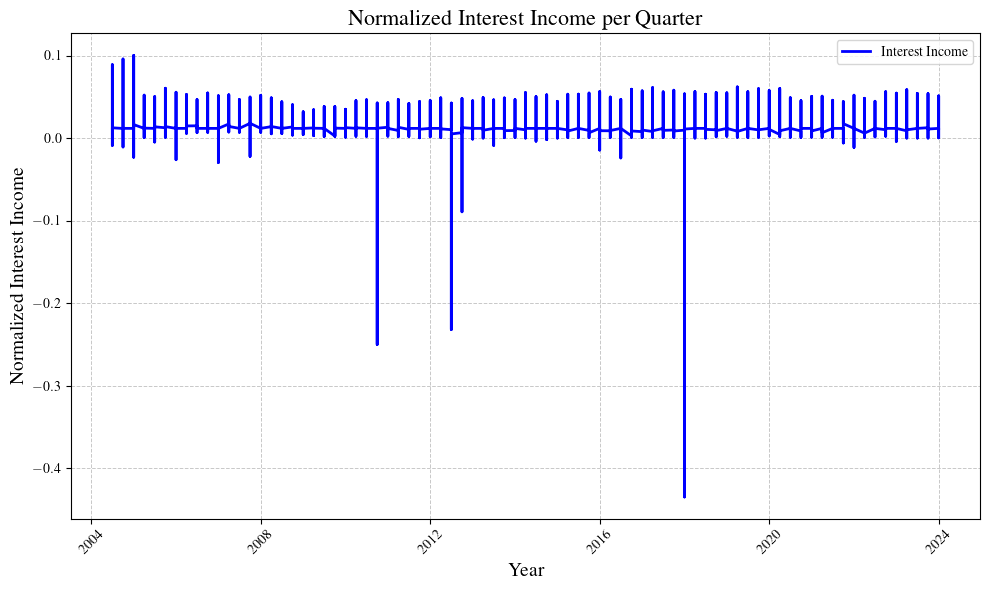

In [70]:
# Create a figure with size 10x6
plt.figure(figsize=(10, 6))

# Plot the normalized interest income series
plt.plot(interest_income_series, color='blue', linestyle='-', linewidth=2, label='Interest Income')

# Add title and labels
plt.title('Normalized Interest Income per Quarter', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Normalized Interest Income', fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Rotate x-axis labels if they are dates
plt.xticks(rotation=45)

# Add a legend if needed
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

#### Training and Testing Data:

In [71]:
Length = len(interest_income_series.values)
Train = int(Length*0.9)
Test = Length - Train

data = interest_income_series.values
train_set, test_set = data[:-Test], data[-Test:]

print('shapes:', data.shape, train_set.shape, test_set.shape)

shapes: (235236,) (211712,) (23524,)


In [72]:
train_set_dates = interest_income_series.head(Train).index  # for plotting
test_set_dates = interest_income_series.tail(Test).index 

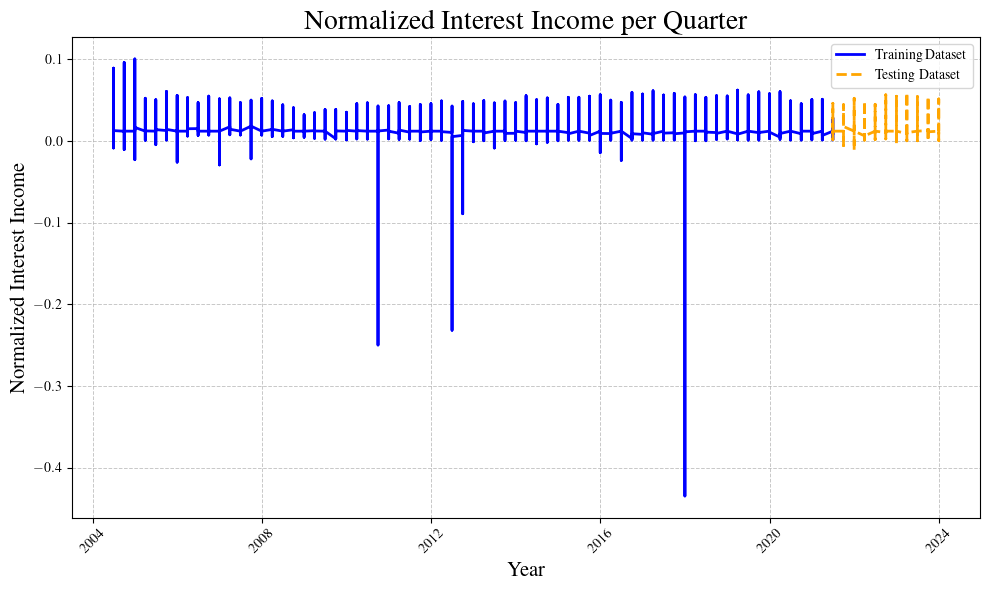

In [73]:
# Create a figure with size 10x6
plt.figure(figsize=(10, 6))

# Plot the training and testing datasets
plt.plot(train_set_dates, train_set, color='blue', linestyle='-', linewidth=2, label='Training Dataset')
plt.plot(test_set_dates, test_set, color='orange', linestyle='--', linewidth=2, label='Testing Dataset')

# Add title and labels with customized font sizes
plt.title('Normalized Interest Income per Quarter', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Interest Income', fontsize=15)

# Add a legend to distinguish between the datasets
plt.legend(loc='best')

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Rotate x-axis labels if they are dates
plt.xticks(rotation=45)

# Improve layout to ensure everything fits within the figure area
plt.tight_layout()

# Show the plot
plt.show()

In [74]:
Lag = 10
model = AutoReg(train_set, lags = Lag)
trained_model = model.fit()

In [75]:
predictions = trained_model.predict(start=Train, end=Train + Test - 1)

error = mse(test_set, predictions)

print(f'test MSE: {error:.3}')
print(f'test RMSE: {error ** 0.5:.3}')

test MSE: 3.56e-06
test RMSE: 0.00189


#### Plot of Predictions vs. Truth:

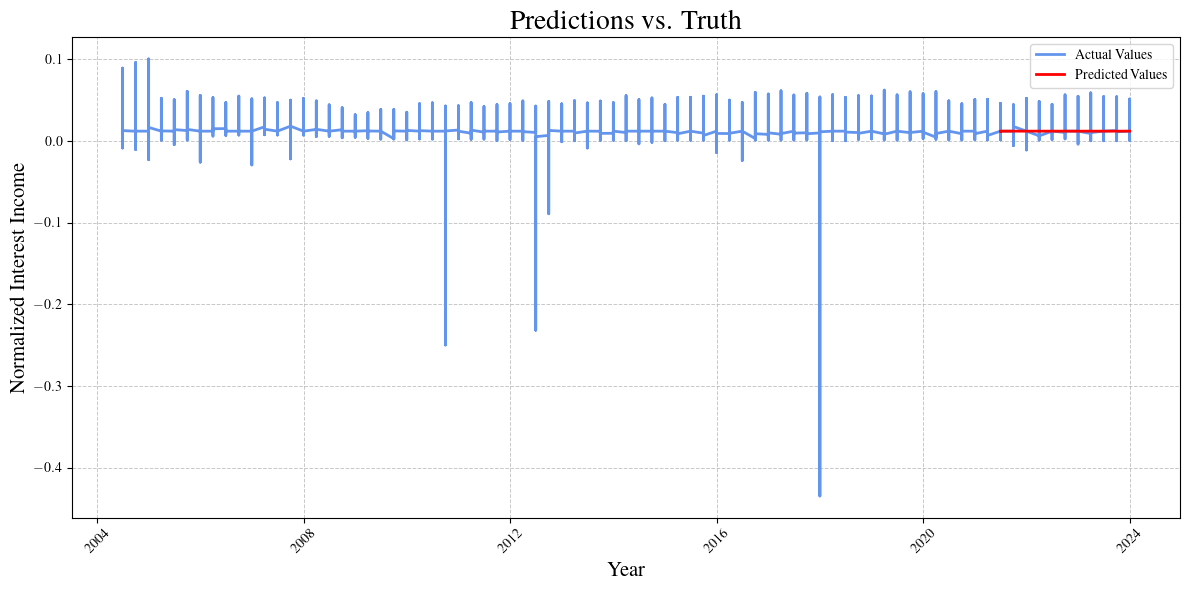

In [76]:
# Create a figure with size 12x6
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(interest_income_series.index, interest_income_series, color='cornflowerblue', linestyle='-', linewidth=2, label='Actual Values')

# Plot the predicted values
plt.plot(test_set_dates, predictions, color='red', linestyle='-', linewidth=2, label='Predicted Values')

# Add title and labels with customized font sizes
plt.title('Predictions vs. Truth', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Interest Income', fontsize=15)

# Add a legend to differentiate between the lines
plt.legend(loc='best')

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Rotate x-axis labels if they are dates for better readability
plt.xticks(rotation=45)

# Improve layout to ensure all elements fit within the figure area
plt.tight_layout()

# Show the plot
plt.show()

#### ACF and PACF Plots:

<Figure size 1200x600 with 0 Axes>

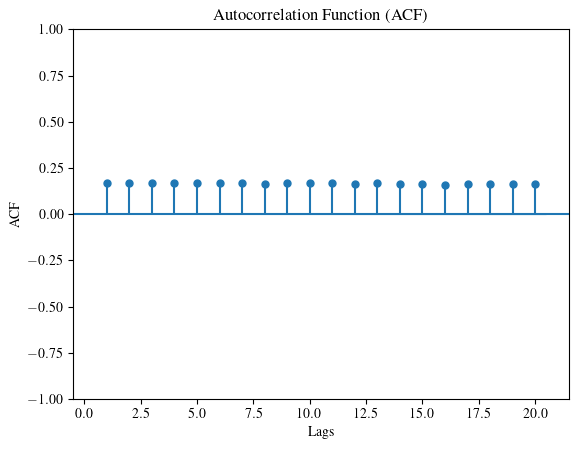

In [77]:
plt.figure(figsize=(12, 6))
plot_acf(data, lags=20, zero=False)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)');

<Figure size 1200x600 with 0 Axes>

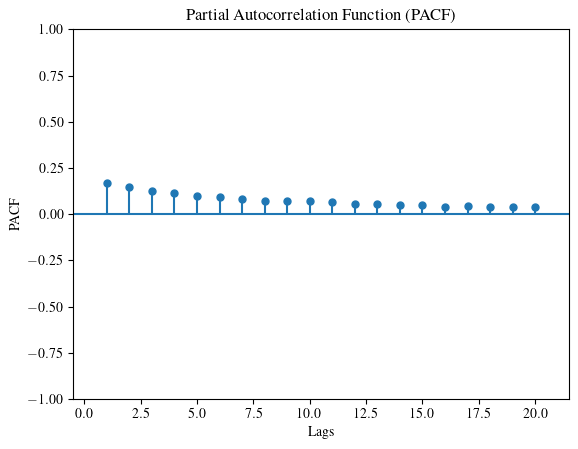

In [78]:
plt.figure(figsize=(12, 6))
plot_pacf(data, lags=20, zero=False)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)');

**Interpretation:** 

-  Notice the decay pattern in the ACF plot. As the lag increases, the correlation values should generally decrease and approach zero. A slow decay suggests a persistent correlation, while a rapid decay indicates a lack of long-term dependence.
-  In the PACF plot, observe if the correlation drops off after a certain lag. A sudden cutoff suggests that the direct relationship exists only up to that lag.

#### Compare AIC and BIC of AR Model with Different Lags:

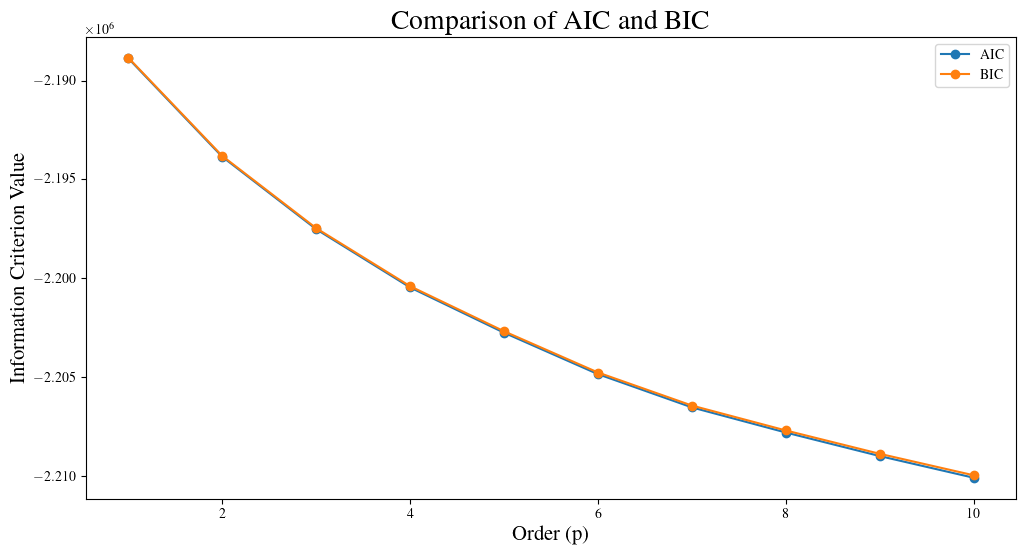

In [79]:
# Create a figure with size 12x6
plt.figure(figsize=(12, 6))

# Fit AutoReg models with different orders and compare AIC and BIC
max_order = 10
aic_values = []
bic_values = []

for p in range(1, max_order + 1):
    model = AutoReg(data, lags=p)
    result = model.fit()
    aic_values.append(result.aic)
    bic_values.append(result.bic)

# Plot AIC and BIC values
order = range(1, max_order + 1)
plt.plot(order, aic_values, marker='o', label='AIC')
plt.plot(order, bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)', fontsize = 15)
plt.ylabel('Information Criterion Value', fontsize = 15)
plt.title('Comparison of AIC and BIC', fontsize = 20)
plt.legend()
plt.show()

#### Determine the appropriate order (p):

In [80]:
max_order = 10
p_values = []

for p in range(1, max_order + 1):
    model = AutoReg(data, lags=p)
    result = model.fit()
    residuals = result.resid

    result = acorr_ljungbox(residuals, lags=[p])
    p_value = result.iloc[0,1]
    p_values.append(p_value)
    
# Find the lag order with non-significant autocorrelation
threshold = 0.05
selected_order = np.argmax(np.array(p_values) < threshold) + 1
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)

P Values:  [np.float64(9.914164623947504e-33), np.float64(1.0226816604282321e-84), np.float64(2.626974737875117e-141), np.float64(3.0220977409318902e-192), np.float64(1.2319321105620387e-235), np.float64(9.676496859242133e-267), np.float64(4.678002709619043e-288), np.float64(1.458517869278922e-303), np.float64(8.97090759662722e-308), np.float64(3.7624265585622764e-306)]
Selected Order (p): 1


**Interpretation:** The lag order with no significant autocorrelation in the residuals is considered suitable for the model.

#### Cross Validation:

In [81]:
max_order = 20
best_order = None
best_mse = np.inf

tscv = TimeSeriesSplit(n_splits=5)  
for p in range(1, max_order + 1):
    mse_scores = []
    
    for train_index, test_index in tscv.split(data):
        model = AutoReg(train_set, lags=p)
        result = model.fit()
        predictions = result.predict(start=len(train_set), end=len(train_set) + len(test_set) - 1)
        
        mean_sq_error = mse(test_set, predictions)
        mse_scores.append(mean_sq_error )
    
    avg_mse = np.mean(mse_scores)

    if avg_mse < best_mse:
        best_mse = avg_mse
        best_order = p

print("Best Lag Order (p):", best_order)


Best Lag Order (p): 20


#### Forecasting:

In [82]:
error_list = []
for i in range(1, 31):
    model = AutoReg(train_set, lags=i)
    model_fit = model.fit()
    
    # Make prediction
    predicted = model_fit.predict(start=len(train_set), end=len(train_set))
    
    # Extract the single element from the predicted array
    predicted_value = float(predicted[0])
    
    actual = test_set[0]
    error_list.append(abs(actual - predicted_value))

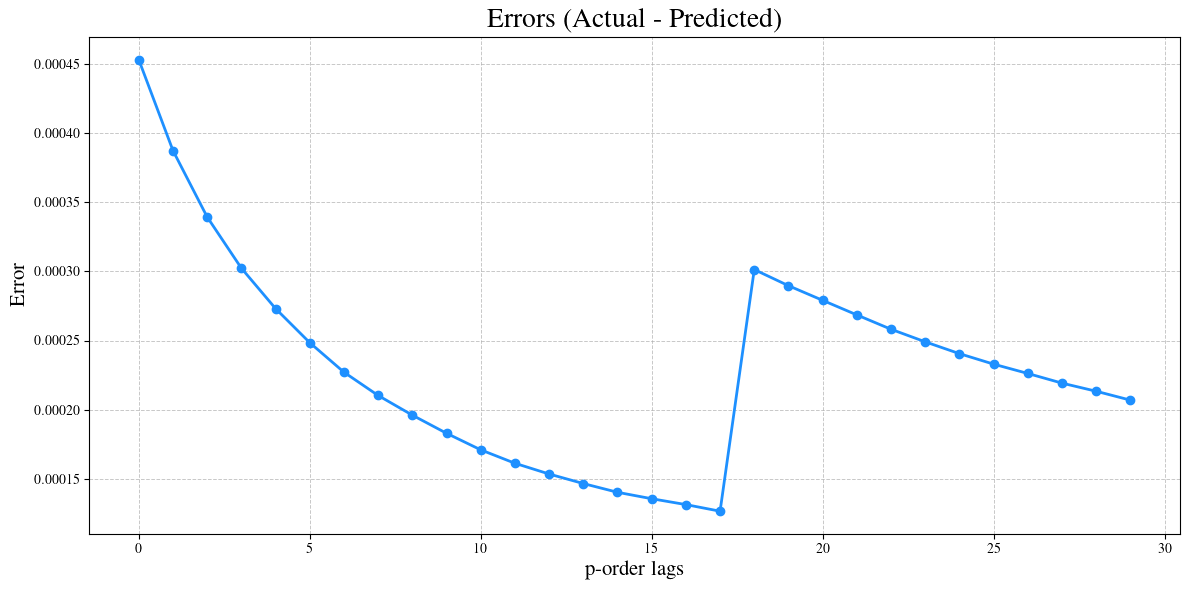

In [83]:
# Create a figure with size 12x6
plt.figure(figsize=(12, 6))

# Plot the error list with markers
plt.plot(error_list, color='dodgerblue', marker='o', linestyle='-', linewidth=2, markersize=6)

# Add title and labels with customized font sizes
plt.title("Errors (Actual - Predicted)", fontsize=20)
plt.xlabel("p-order lags", fontsize=15)
plt.ylabel("Error", fontsize=15)

# Add gridlines for better readability
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Improve layout to ensure all elements fit within the figure area
plt.tight_layout()

# Show the plot
plt.show()

### - Regression Trees:

#### Data Preparation:

In [84]:
df2 = df.dropna(subset = ['Total Assets'])
df2 = df2.sort_values(by = ['Total Assets'])

In [85]:
# Display the number of missing values per column
missing_values = df2.isnull().sum()

# Sort the columns by the number of missing values (ascending order)
sorted_missing_values = missing_values.sort_values()

# Filter the DataFrame to include only columns with fewer missing values (e.g., less than a threshold)
# Set a threshold for maximum allowed missing values (e.g., 500)
threshold = 500
filtered_columns = sorted_missing_values[sorted_missing_values <= threshold].index

# Create a new DataFrame with the filtered columns
df2 = df2[filtered_columns].dropna()

In [86]:
df2.shape

(73456, 66)

In [87]:
# Making Lagged Variable for Normalized Interest Income
new_dfs = []

# Iterate over unique quarters
for i in df2['RSSD ID'].unique():
  new_df_i = df2.loc[df2['RSSD ID']==i,:]
  new_df_i = new_df_i.sort_values(['Year', 'Quarter'])
  new_df_i["Lagged Income"] = new_df_i['Normalized Interest Income per Quarter'].shift(1)
  new_dfs.append(new_df_i)

df3 = pd.concat(new_dfs, ignore_index=True)

In [88]:
# Making a large bank variable

new_dfs = []

# Iterate over unique quarters
for quarter in df3['Quarter'].unique():
    new_df_quarter = df3[df3['Quarter'] == quarter]
    
    # Iterate over unique years within each quarter
    for year in new_df_quarter['Year'].unique():
        new_df_quarter_year = new_df_quarter[new_df_quarter['Year'] == year].copy()
        
        # Calculate mean total assets for the current slice and create 'Large Bank' variable
        mean_assets = new_df_quarter_year['Total Assets'].mean()
        new_df_quarter_year['Large Bank'] = new_df_quarter_year['Total Assets'] > mean_assets
        
        # Append the processed slice to the list
        new_dfs.append(new_df_quarter_year)

# Concatenate all processed slices into a single DataFrame
df4 = pd.concat(new_dfs, ignore_index=True)

# Display the head of the final DataFrame
df4.head()

,RSSD ID,Firm Legal Name,FR District Code,Total Assets,Reporting Date,Year,Quarter,Normalized Interest Income per Quarter,3 Yr-1 Yr_spread,2 Yr-1 Yr_spread,...,2 Yr,1 Yr,6 Mo,3 Mo,1 Mo,7 Yr,20 Yr-1 Mo_spread,UNRATE,Lagged Income,Large Bank
0,1247334,CAPITOL BANCORP LTD.,7,2867800.0,2004-03-31,2004,1,0.014453,0.941613,0.465161,...,1.686613,1.221452,1.003548,0.93371,0.909677,3.501452,3.968226,5.6,NaN,False
1,2595939,BUILDERS FINANCIAL CORPORATION,7,407516.0,2004-03-31,2004,1,0.013607,0.941613,0.465161,...,1.686613,1.221452,1.003548,0.93371,0.909677,3.501452,3.968226,5.6,NaN,False
2,2322304,FIRST MARINER BANCORP,5,1092393.0,2004-03-31,2004,1,0.013859,0.941613,0.465161,...,1.686613,1.221452,1.003548,0.93371,0.909677,3.501452,3.968226,5.6,NaN,False
3,1056125,"CHAMBANCO, INC.",10,41898.0,2004-03-31,2004,1,0.013581,0.941613,0.465161,...,1.686613,1.221452,1.003548,0.93371,0.909677,3.501452,3.968226,5.6,NaN,False
4,1839270,SURETY CAPITAL CORPORATION,11,62276.0,2004-03-31,2004,1,0.016266,0.941613,0.465161,...,1.686613,1.221452,1.003548,0.93371,0.909677,3.501452,3.968226,5.6,NaN,False


In [89]:
df4.shape

(73456, 68)

In [90]:
# Drop NA values
df4 = df4.dropna()

#### Target and Predictor Variable:

##### Set 1:

In [91]:
X= df4[['3 Mo', '10 Yr', 'UNRATE', 'Lagged Income', ' GDP growth', 'Total Assets']]  # variables

y= df4['Normalized Interest Income per Quarter'] #Independent variable PPNR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of train-test splits
print(f'Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}')
X_train.info()

Shape of X_train: (56448, 6), Shape of X_test: (14112, 6)
Shape of y_train: (56448,), Shape of y_test: (14112,)
<class 'pandas.core.frame.DataFrame'>
Index: 56448 entries, 67509 to 18343
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   3 Mo           56448 non-null  float64
 1   10 Yr          56448 non-null  float64
 2   UNRATE         56448 non-null  float64
 3   Lagged Income  56448 non-null  float64
 4    GDP growth    56448 non-null  float64
 5   Total Assets   56448 non-null  float64
dtypes: float64(6)
memory usage: 3.0 MB


In [92]:
from sklearn.metrics import mean_squared_error as mse

# Initialize the regression tree model
reg_tree = DecisionTreeRegressor(max_depth=9, random_state=42)

# Train the model
reg_tree.fit(X_train, y_train)

# Make predictions
y_pred = reg_tree.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 2.394691634307324e-06
R² Score: 0.8125984705776444


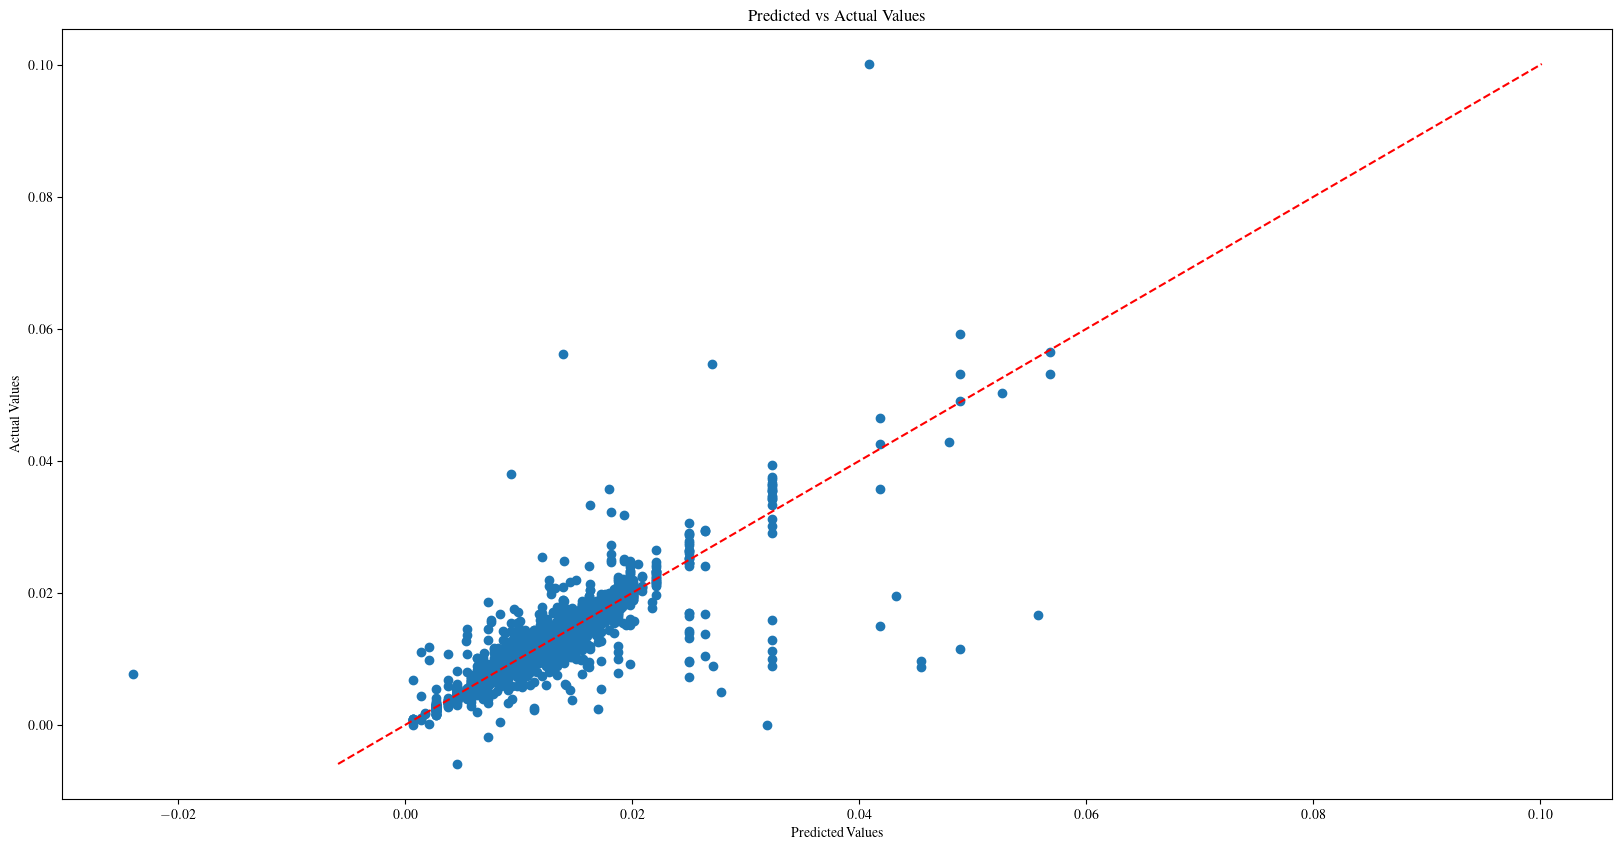

In [93]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of equality
plt.show()

In [94]:
# Check feature importances
importances = reg_tree.feature_importances_
feature_names = X.columns

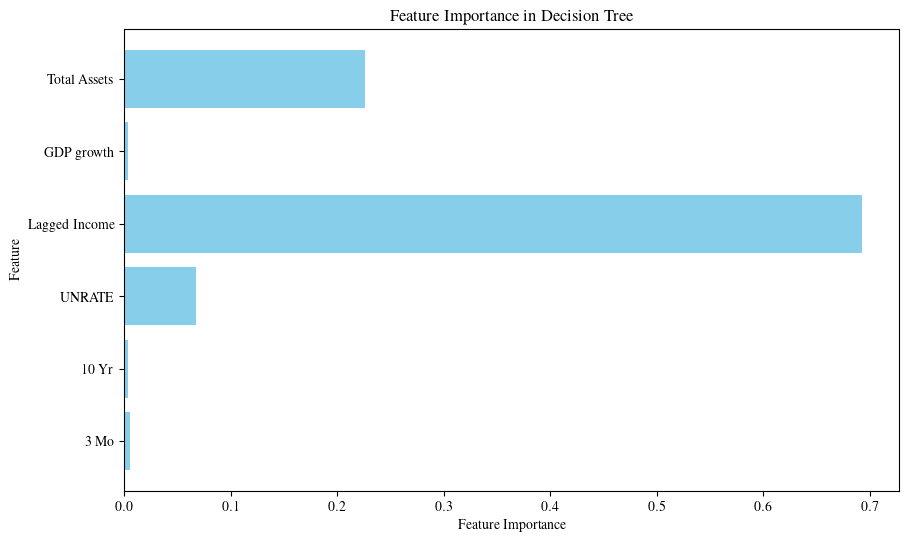

In [95]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()

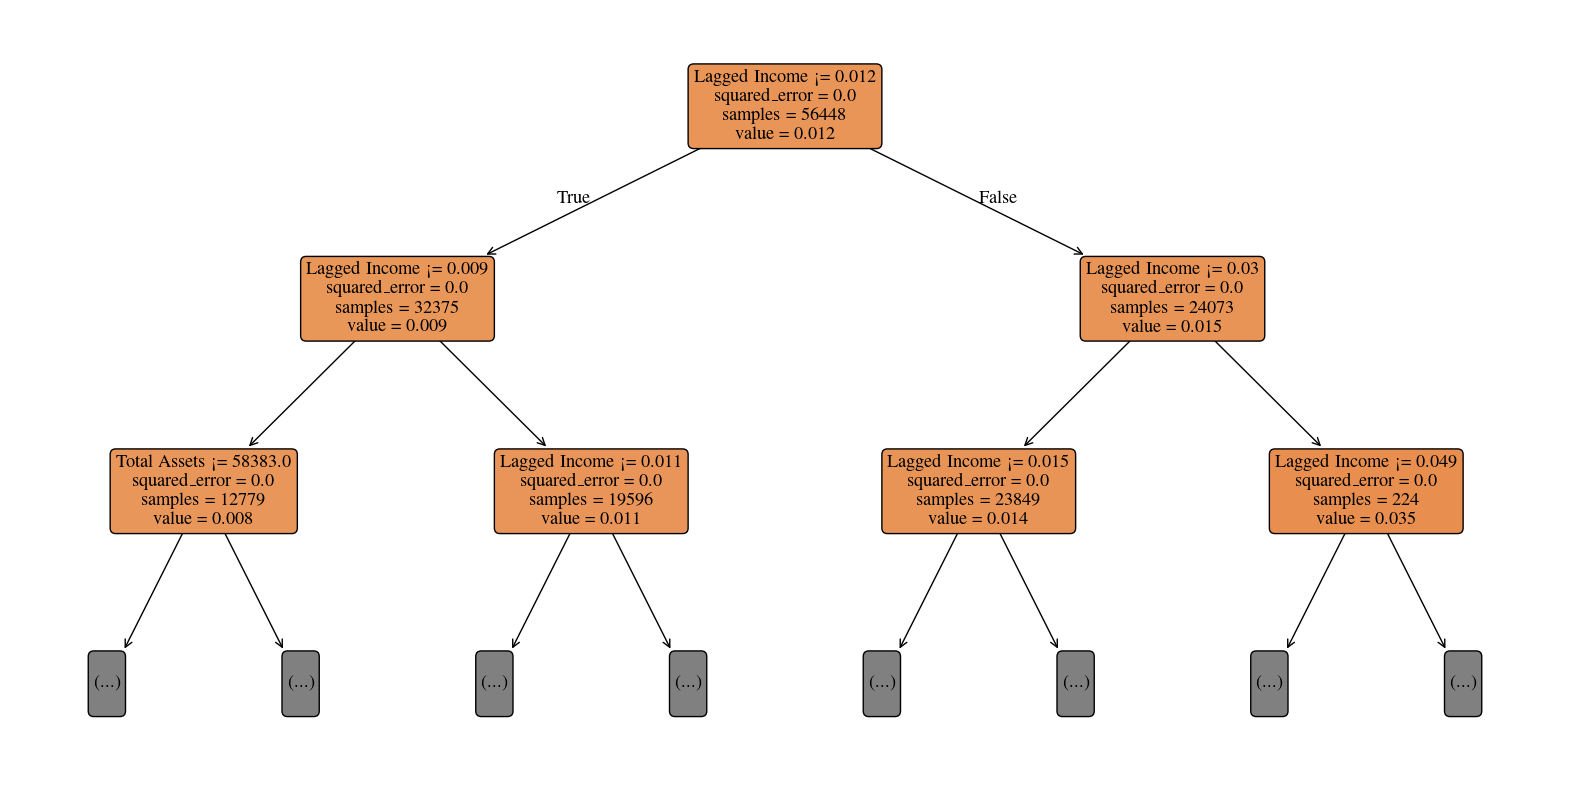

In [96]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plot_tree(reg_tree, feature_names=X.columns, max_depth=2, filled=True, rounded=True)
plt.show()

**Interpretation:** Even though R^2 is high, lagged value is the feature is most importance. That's why this variable appears more in the regression tree.

##### Set 2:

In [97]:
X= df4[['3 Mo', '10 Yr', 'UNRATE', 'Lagged Income', 'GDP', 'Total Assets']]  # variables

y= df4['Normalized Interest Income per Quarter'] #Independent variable PPNR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of train-test splits
print(f'Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}')
X_train.info()

from sklearn.metrics import mean_squared_error as mse

# Initialize the regression tree model
reg_tree = DecisionTreeRegressor(max_depth=9, random_state=42)

# Train the model
reg_tree.fit(X_train, y_train)

# Make predictions
y_pred = reg_tree.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Shape of X_train: (56448, 6), Shape of X_test: (14112, 6)
Shape of y_train: (56448,), Shape of y_test: (14112,)
<class 'pandas.core.frame.DataFrame'>
Index: 56448 entries, 67509 to 18343
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   3 Mo           56448 non-null  float64
 1   10 Yr          56448 non-null  float64
 2   UNRATE         56448 non-null  float64
 3   Lagged Income  56448 non-null  float64
 4   GDP            56448 non-null  float64
 5   Total Assets   56448 non-null  float64
dtypes: float64(6)
memory usage: 3.0 MB
Mean Squared Error: 2.4812467318165803e-06
R² Score: 0.8058249230276578


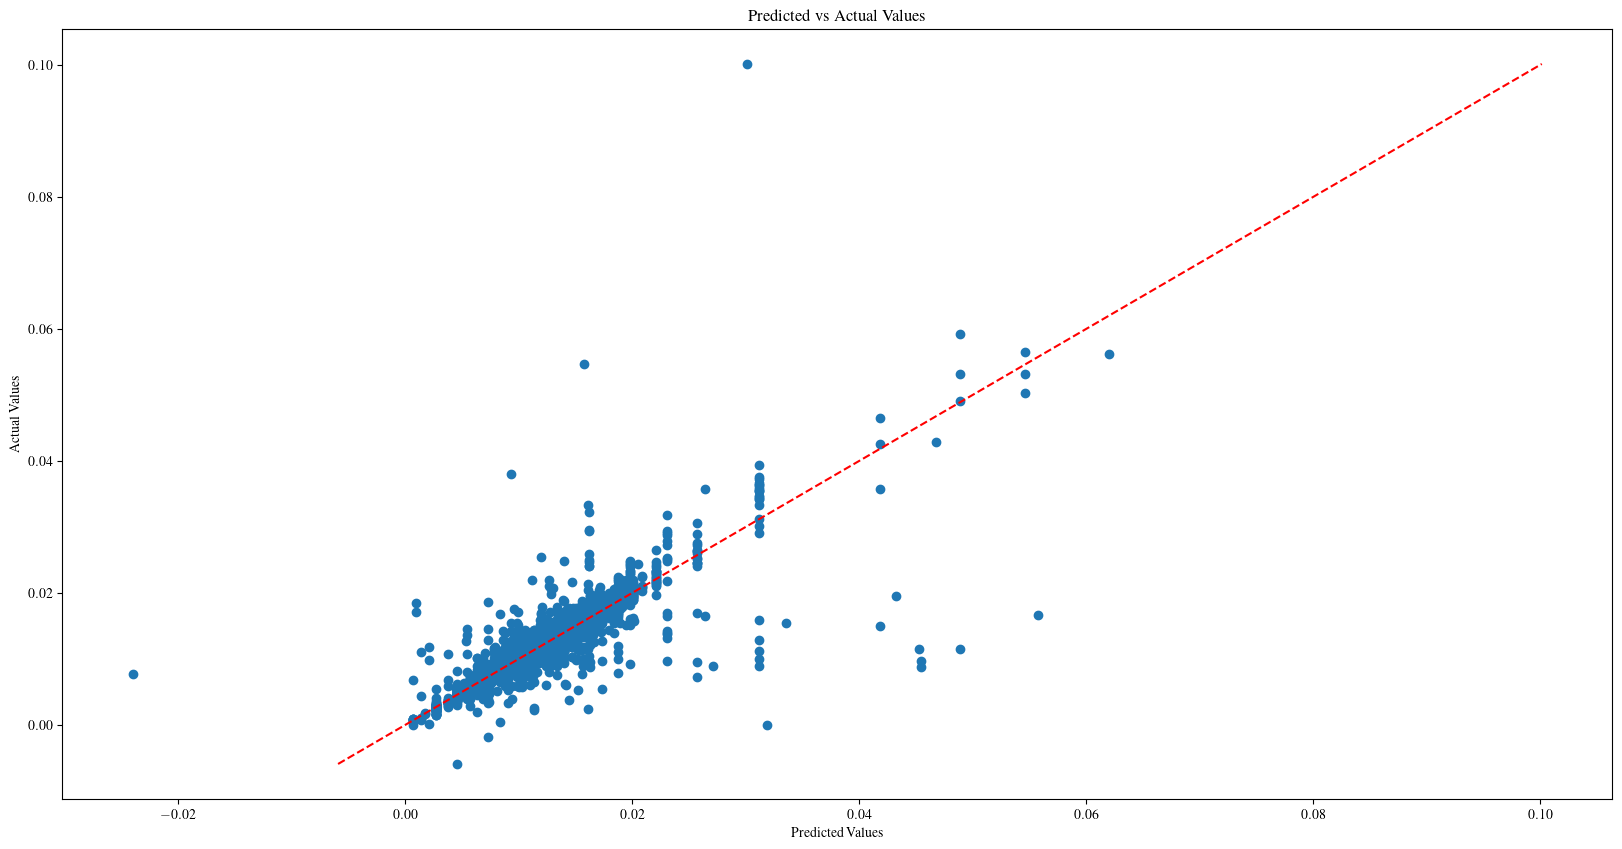

In [98]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of equality
plt.show()

In [99]:
# Check feature importances
importances = reg_tree.feature_importances_
feature_names = X.columns

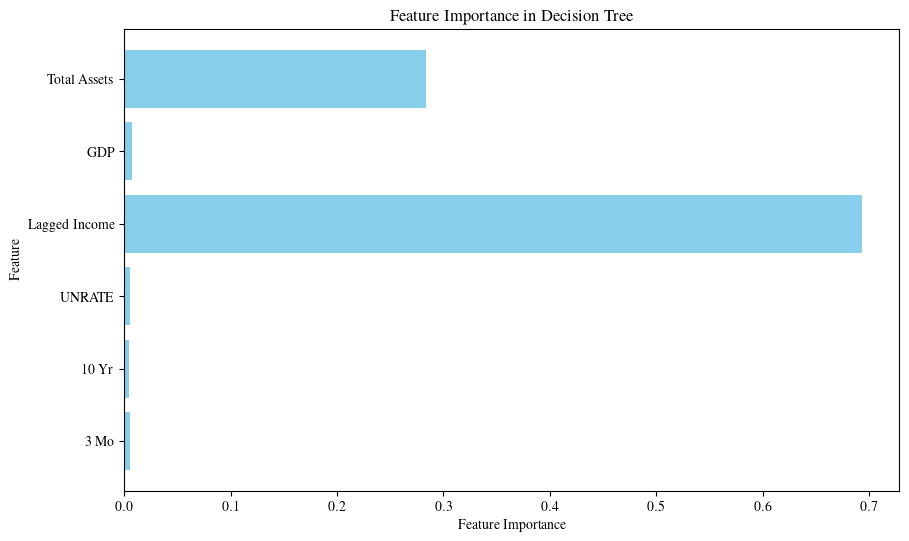

In [100]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()

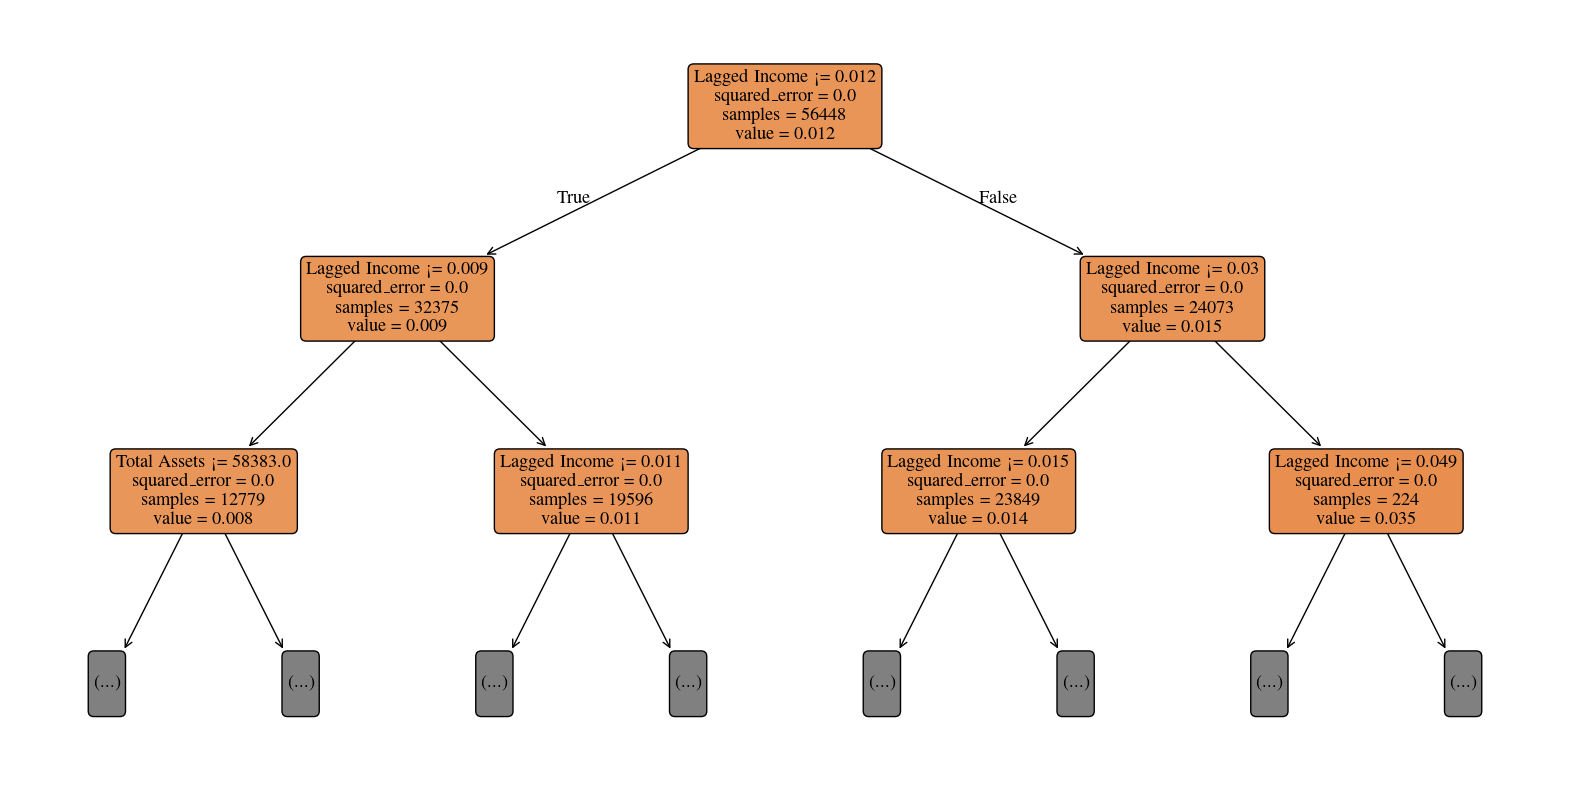

In [101]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plot_tree(reg_tree, feature_names=X.columns, max_depth=2, filled=True, rounded=True)
plt.show()

##### Set 3:

In [102]:
X= df4[['3 Mo', '10 Yr', 'UNRATE', 'Lagged Income', 'GDP', 'Large Bank']]  # variables

y= df4['Normalized Interest Income per Quarter'] #Independent variable PPNR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of train-test splits
print(f'Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}')
X_train.info()

from sklearn.metrics import mean_squared_error as mse

# Initialize the regression tree model
reg_tree = DecisionTreeRegressor(max_depth=9, random_state=42)

# Train the model
reg_tree.fit(X_train, y_train)

# Make predictions
y_pred = reg_tree.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Shape of X_train: (56448, 6), Shape of X_test: (14112, 6)
Shape of y_train: (56448,), Shape of y_test: (14112,)
<class 'pandas.core.frame.DataFrame'>
Index: 56448 entries, 67509 to 18343
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   3 Mo           56448 non-null  float64
 1   10 Yr          56448 non-null  float64
 2   UNRATE         56448 non-null  float64
 3   Lagged Income  56448 non-null  float64
 4   GDP            56448 non-null  float64
 5   Large Bank     56448 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 2.6 MB
Mean Squared Error: 6.267624336617668e-06
R² Score: 0.5095141396496858


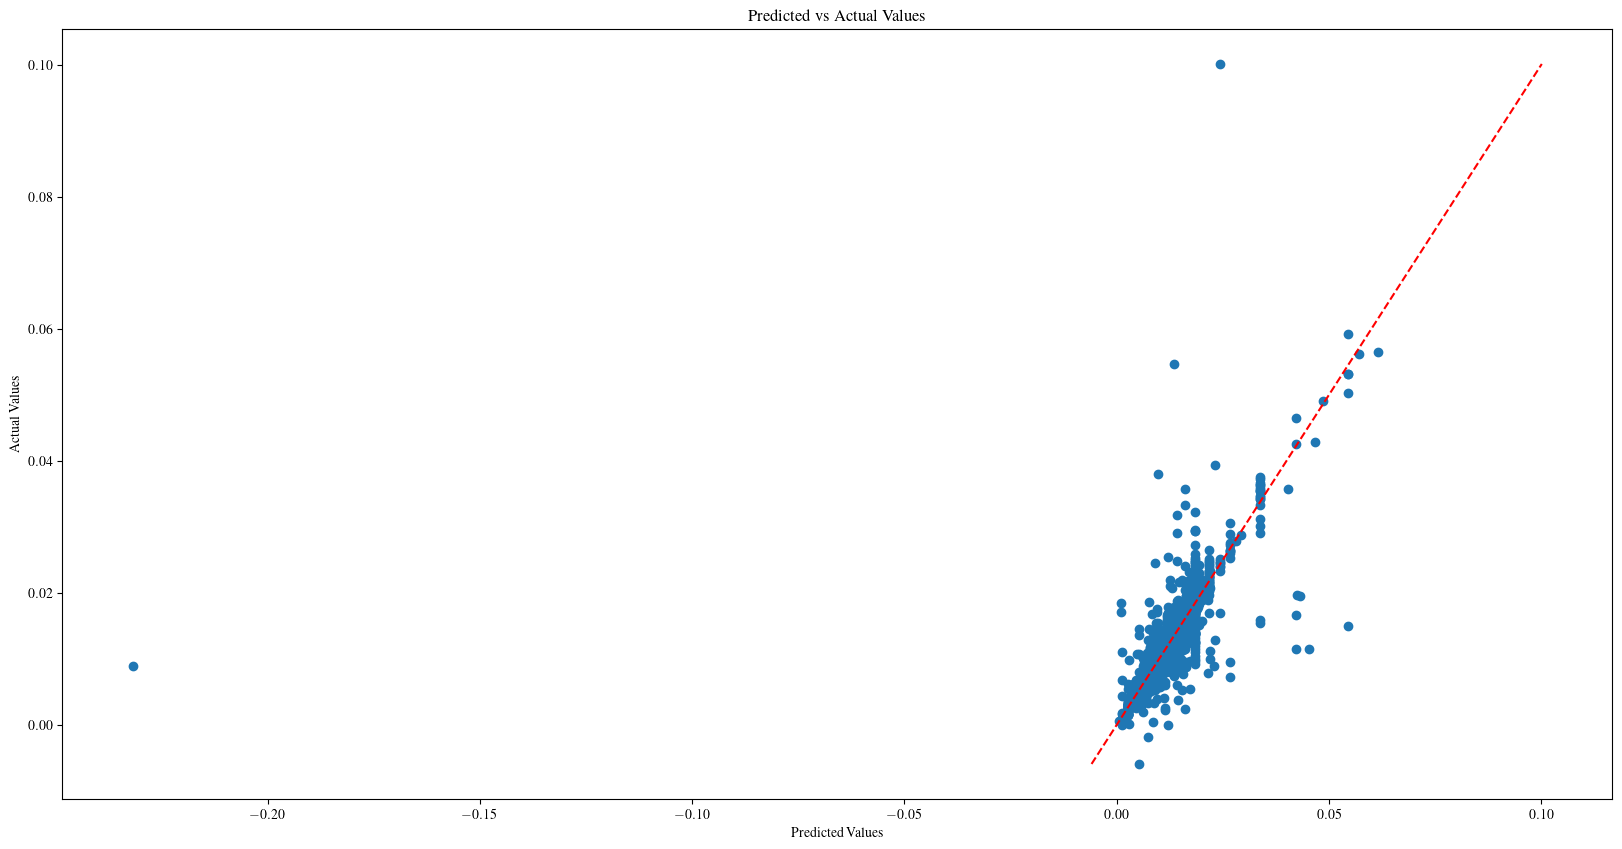

In [103]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of equality
plt.show()

In [104]:
# Check feature importances
importances = reg_tree.feature_importances_
feature_names = X.columns

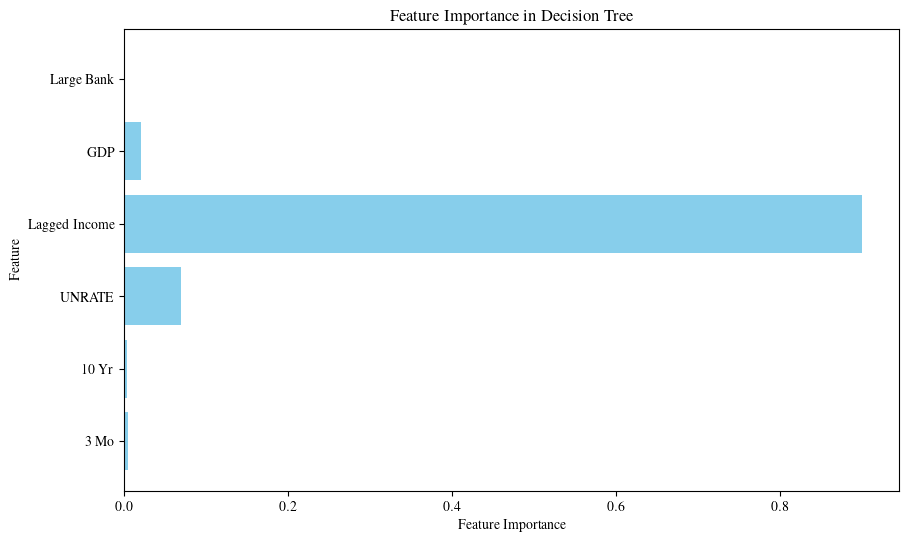

In [105]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()

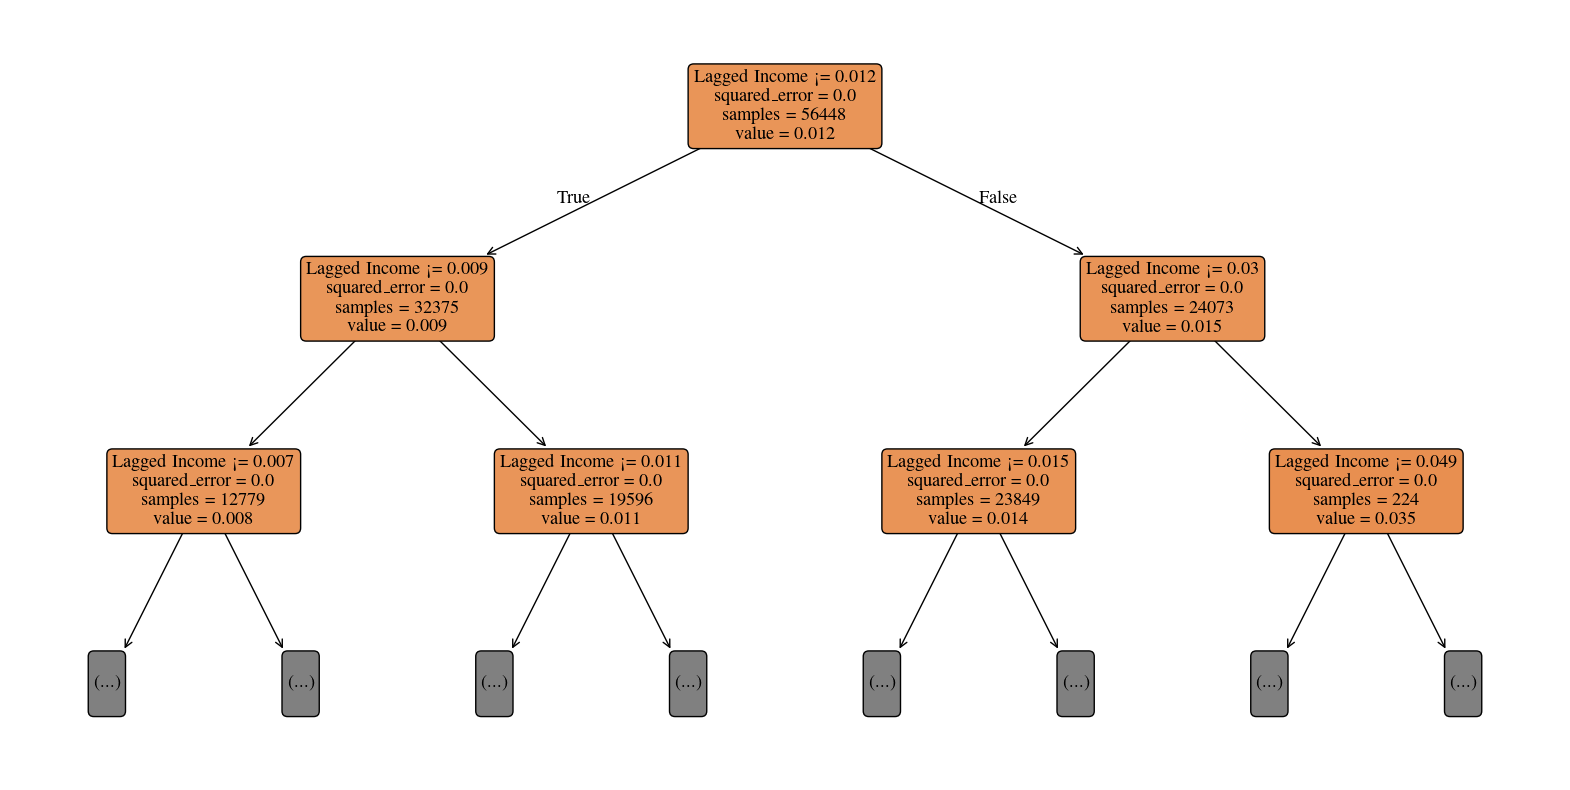

In [106]:
# Plot the regression tree
plt.figure(figsize=(20,10))
plot_tree(reg_tree, feature_names=X.columns, max_depth=2, filled=True, rounded=True)
plt.show()

**Interpretation:** Lagged Income is the feature with most importance. Set 1 gave best MSE.

### - Linear Regression Model:

In [107]:
## Fitting a model w/o Lagged Income variable:

from sklearn.metrics import mean_squared_error as mse

X= df4[['3 Mo', '1 Yr', '3 Yr', '10 Yr', 'UNRATE', 'GDP']]  # Predictors 

y= df4['Normalized Interest Income per Quarter'] #  Target variable

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean Squared Error: 7.18022784252618e-06
R² Score: 0.43809647137319074
Coefficients: [ 0.00023835  0.00312404 -0.0022114   0.00108041  0.00036755 -0.00087276]
Intercept: 0.01169121886085018


In [108]:
## Fitting a model w Lagged Income variable:

from sklearn.metrics import mean_squared_error as mse

X= df4[['3 Mo', '1 Yr', '3 Yr', '10 Yr', 'Lagged Income', 'UNRATE', 'GDP']]  # variables

y= df4['Normalized Interest Income per Quarter'] #Independent variable PPNR

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean Squared Error: 2.386657879021632e-06
R² Score: 0.813227168655499
Coefficients: [ 0.00011932  0.00122943 -0.00064074  0.00042783  0.00226727  0.00013523
 -0.00036037]
Intercept: 0.011687905863004406


### - LASSO Regression:

In [109]:
from sklearn.metrics import mean_squared_error as mse

X= df4[['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', 'GDP', 'UNRATE', 'Lagged Income']]  # variables

y= df4['Normalized Interest Income per Quarter'] #Independent variable PPNR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Lasso model
alpha = 0.05  # regularization strength
model = Lasso(alpha = alpha)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean Squared Error: 1.038501296992819e-05
R² Score: 0.18729940600536665
Coefficients: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.31853009e-07 -0.00000000e+00
  0.00000000e+00]
Intercept: 0.018797183602851094
